In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [4]:
dataset_name = "W13_comb"

In [5]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (68625, 5150)
Wall time: 3.49 s


In [6]:
####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )
try:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
except:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

var_type (5173, 12)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)


In [7]:
fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

In [8]:
## augment dataset
# pan_dataset_values
# census data
# 

pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)    

In [9]:
num_to_wave = {x:"W"+str(x) for x in range(1,14)}
num_to_weight = { y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,14) }
weights = BES_Panel[list(num_to_weight.values())].copy()

In [10]:
# http://www.britishelectionstudy.com/data-object/2017-bes-constituency-results-with-census-and-candidate-data/
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

pano_var_dict = {int(x.replace("panoW","")):x for x in BES_Panel.columns if "pano" in x}
sorted_pano_vars = [ pano_var_dict[x] for x in sorted( pano_var_dict.keys() ) ]

BES_reduced_with_na["pano"] = BES_Panel[sorted_pano_vars].bfill(axis=1).iloc[:, 0]


# len()
census_vars = [x for x in BES_census_data.columns if re.match('c\w',x) ]
census_vars.append("leaveHanretty")
census_vars.append("remainHanretty")
census_vars.append("pano")
# ConstituencyType
BES_reduced_with_na = pd.merge(BES_reduced_with_na, BES_census_data[census_vars], how = 'left', on = 'pano')


BES_census_data (632, 308)


In [11]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [12]:
def get_base(im_var, waves=None, noNans = False):

    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
        
    immig_vars = [im_var+x for x in wave_list]
    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()
        
        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
        
        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset

In [44]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
             "ukCoopMovement",
             "likeLab", "decidedVote", "leftRight", 
             "partyMember", "trustMPs", "electionInterest"]

# "pid", "infoSource", "ptv",
# im_var = "immigCultural"
# imvar_list = ["ptvLab"]

# likeCon, likeLab, pid???, decidedVote, infoSource???, leftRight, ptv???, partyMember, trustMPs, electionInterest
# dutyToVote2

imvar_list.extend(["partyId"])

num = 0
for im_var in imvar_list:
    print(im_var)
    immig, mask = get_base(im_var,noNans = False)
    immig.columns = ["Delta_"+x for x in immig.columns]
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1

immigEcon
immigCultural
immigSelf
immigrationLevel
immigContributeTake
immigrantsWelfareState
controlImmig
effectsEUImmigration
euPriorityBalance
changeImmig
changeImmigLab
govtHandleImmig
labHandleImmig
asylumMore
euMore
noneuMore
studentsMore
familiesMore
ukCoopMovement
likeLab
decidedVote
leftRight
partyMember
trustMPs
electionInterest
partyId


In [14]:
# lr_pos =  [x for x in BES_reduced.columns if re.match("lrCon|lrLab",x)]
# lr_pos.remove('lrConW10__Right')
# lr_pos

In [15]:
# immigDiff

In [16]:
# immigDiff = BES_reduced_with_na[lr_pos].diff(axis=1)[lr_pos[1::2]]

In [ ]:
# lrLab-lrCon

In [36]:
Treatment = "partyId-none(delta)"

In [26]:
var_stub = "partyId"
var_list = [x for x in BES_reduced.columns if re.match(var_stub+"W\d+_No - none",x)]
var_stub_list = ["partyId","partyIdSqueeze","'partyIdStrength", "pid", "generalElectionVote", "ashcroft", "generalElectionCertainty"]
# base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
var_list

['partyIdW1_No - none',
 'partyIdW2_No - none',
 'partyIdW3_No - none',
 'partyIdW4_No - none',
 'partyIdW6_No - none',
 'partyIdW7_No - none',
 'partyIdW8_No - none',
 'partyIdW9_No - none',
 'partyIdW10_No - none',
 'partyIdW11_No - none',
 'partyIdW12_No - none',
 'partyIdW13_No - none']

In [62]:
party_id_none_delta = BES_reduced[var_list].astype('float').diff(axis=1).drop(var_list[0],axis=1)
party_id_none_delta
var_list = var_list[1:]
var_list


['partyIdW2_No - none',
 'partyIdW3_No - none',
 'partyIdW4_No - none',
 'partyIdW6_No - none',
 'partyIdW7_No - none',
 'partyIdW8_No - none',
 'partyIdW9_No - none',
 'partyIdW10_No - none',
 'partyIdW11_No - none',
 'partyIdW12_No - none',
 'partyIdW13_No - none']

In [43]:
# var_list = immigDiff.columns
# var_stub_list = ['lrLab','lrCon']

In [44]:
# var_list.remove('partydiffconlabW5__There is not much difference between them')
# var_list = var_list[-2:]

In [33]:
print(target_var )
print( int( re.search( 'W(\d+)($|_)', target_var ).groups()[0] ) )

partyIdW1_No - none
1


partyIdW2_No - none 2
missing vals in sample weights: 38414
[0]	validation_0-rmse:0.547826
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.530392
[2]	validation_0-rmse:0.513636
[3]	validation_0-rmse:0.49764
[4]	validation_0-rmse:0.482527
[5]	validation_0-rmse:0.46817
[6]	validation_0-rmse:0.454534
[7]	validation_0-rmse:0.441397
[8]	validation_0-rmse:0.429027
[9]	validation_0-rmse:0.417198
[10]	validation_0-rmse:0.406109
[11]	validation_0-rmse:0.395508
[12]	validation_0-rmse:0.385527
[13]	validation_0-rmse:0.376169
[14]	validation_0-rmse:0.367321
[15]	validation_0-rmse:0.358978
[16]	validation_0-rmse:0.351035
[17]	validation_0-rmse:0.343596
[18]	validation_0-rmse:0.336585
[19]	validation_0-rmse:0.329856
MSE: 0.11, MAE: 0.27, EV: 0.07, R2: -0.75


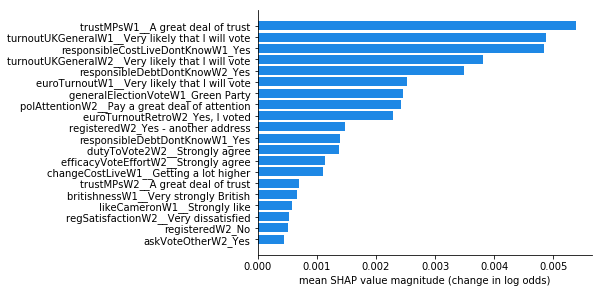

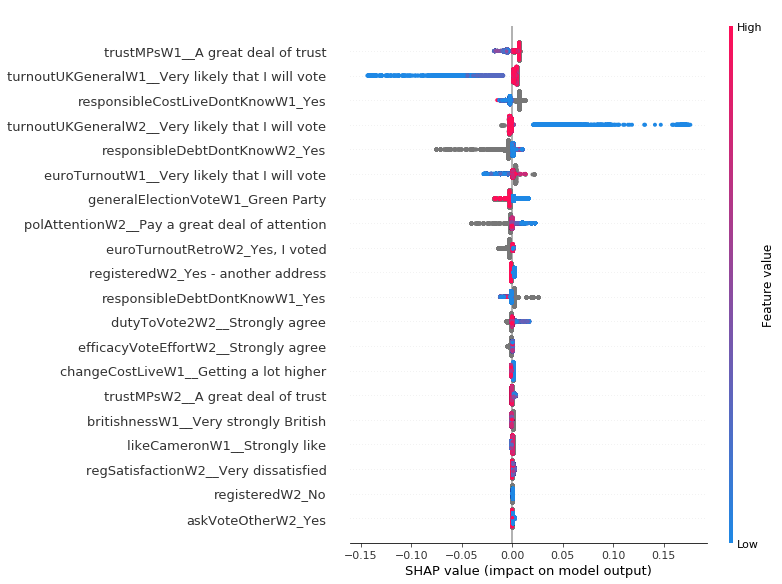

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


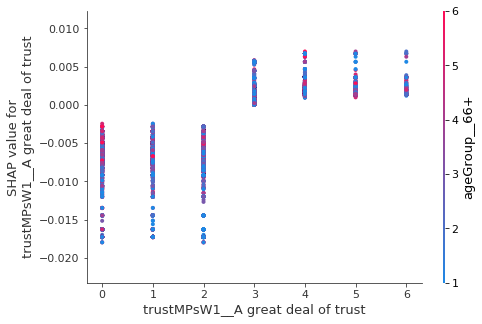

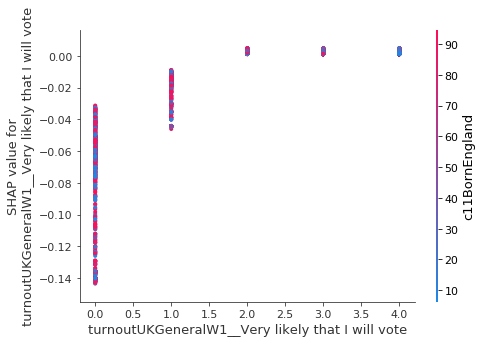

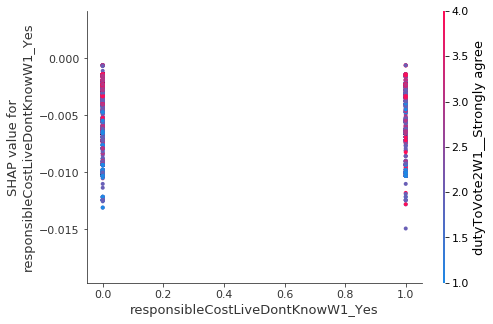

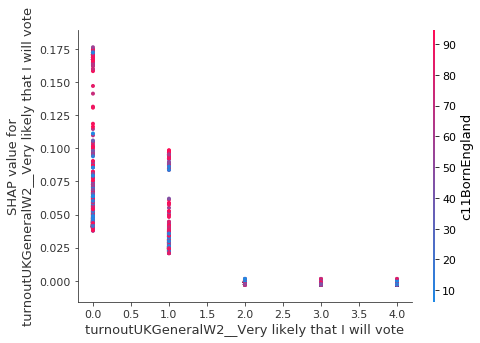

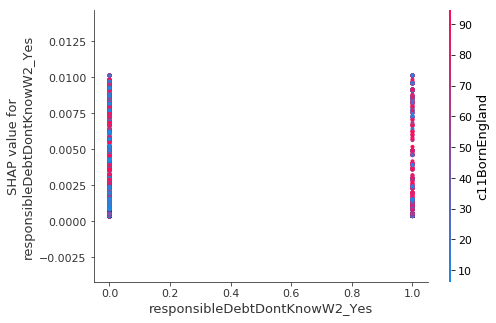

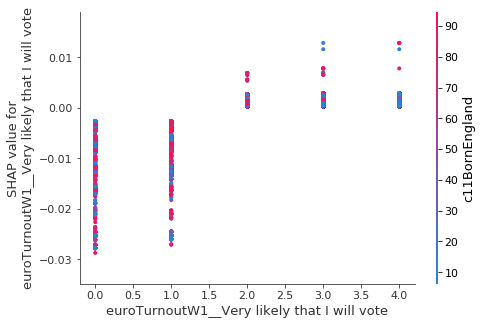

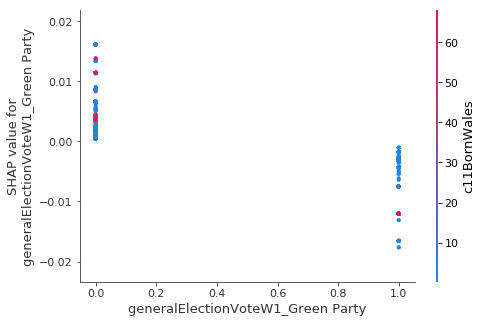

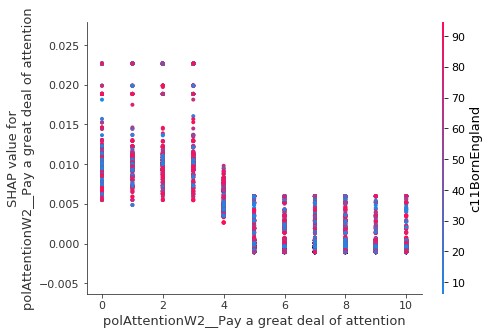

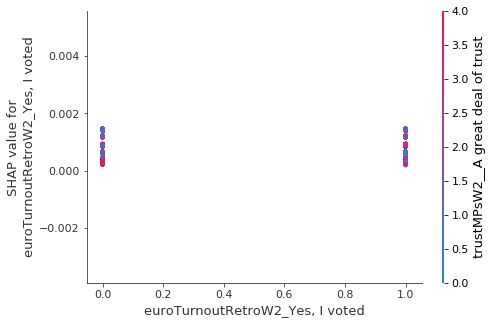

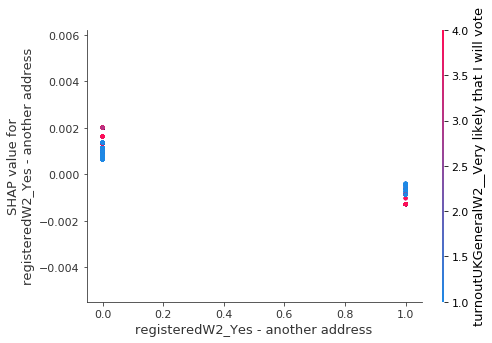

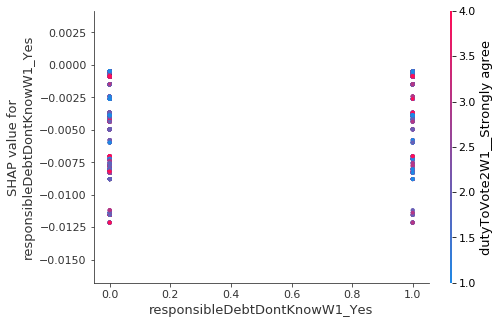

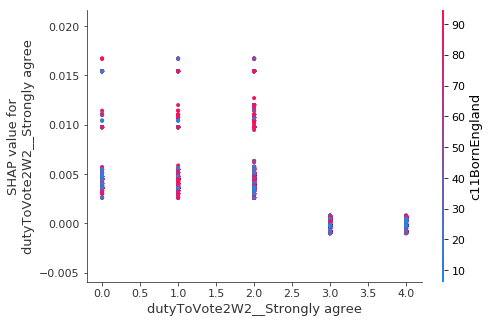

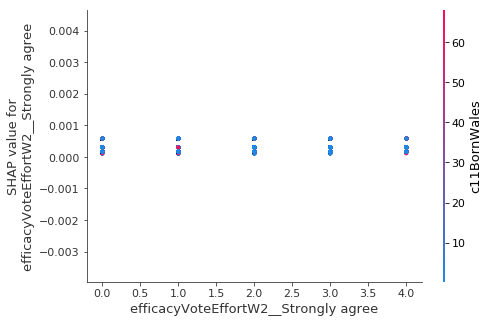

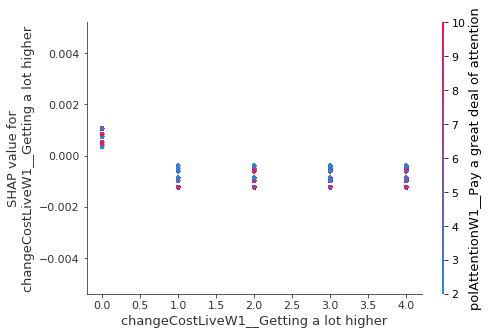

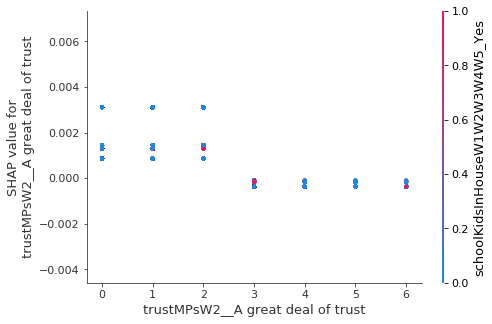

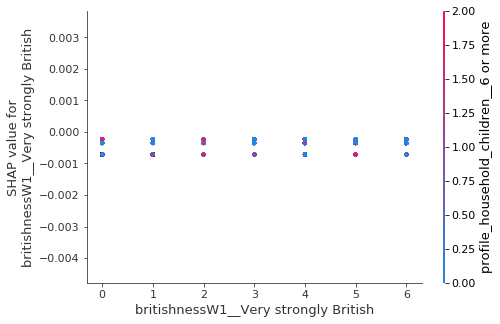

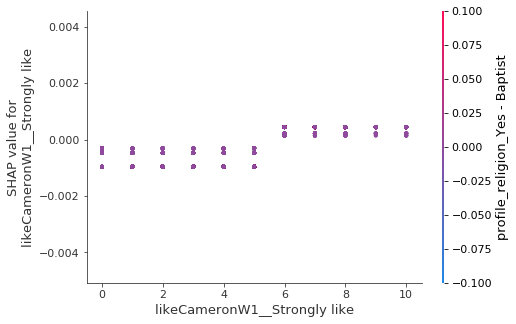

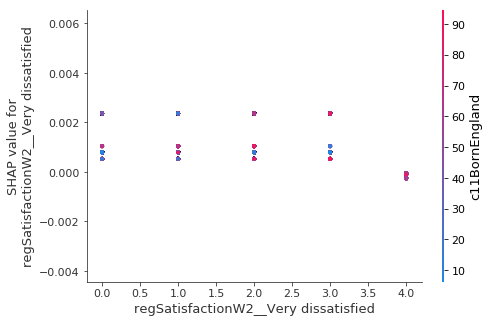

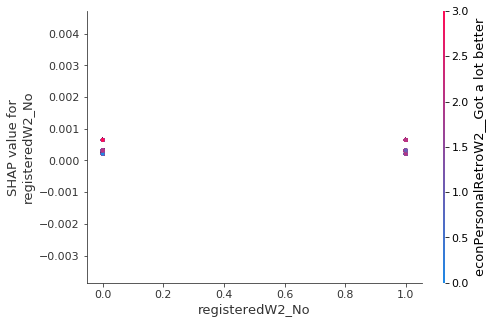

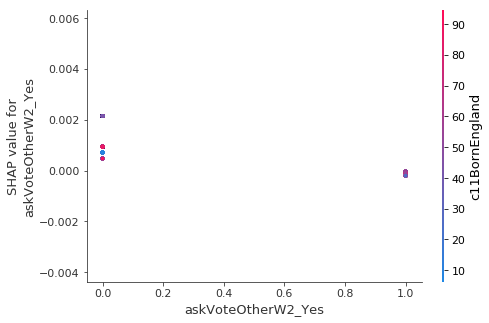

partyIdW3_No - none 3
missing vals in sample weights: 40786
[0]	validation_0-rmse:0.543042
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.525661
[2]	validation_0-rmse:0.509038
[3]	validation_0-rmse:0.4931
[4]	validation_0-rmse:0.478003
[5]	validation_0-rmse:0.46365
[6]	validation_0-rmse:0.450268
[7]	validation_0-rmse:0.437374
[8]	validation_0-rmse:0.425078
[9]	validation_0-rmse:0.413563
[10]	validation_0-rmse:0.402688
[11]	validation_0-rmse:0.392391
[12]	validation_0-rmse:0.382471
[13]	validation_0-rmse:0.373223
[14]	validation_0-rmse:0.364563
[15]	validation_0-rmse:0.356153
[16]	validation_0-rmse:0.348378
[17]	validation_0-rmse:0.341081
[18]	validation_0-rmse:0.334099
[19]	validation_0-rmse:0.327627
MSE: 0.11, MAE: 0.27, EV: 0.09, R2: -0.69


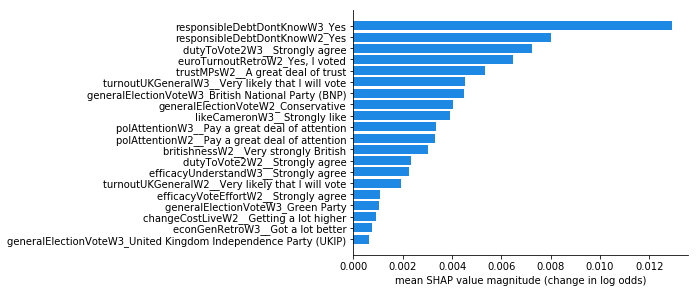

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


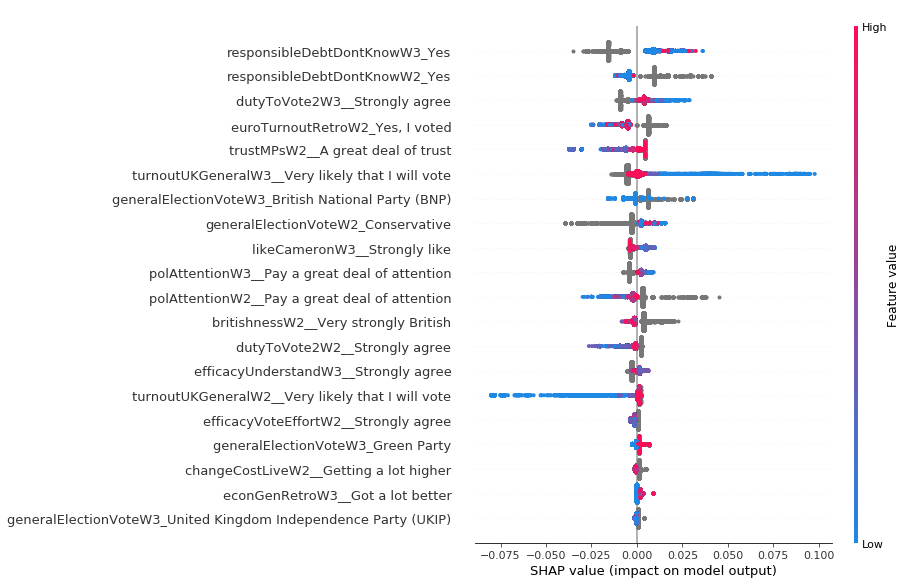

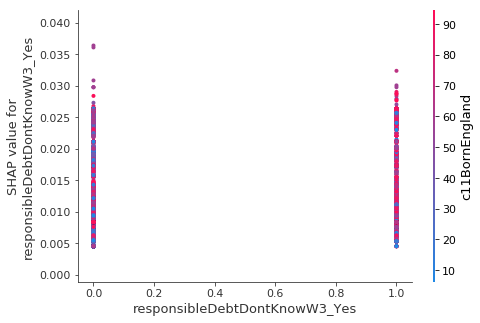

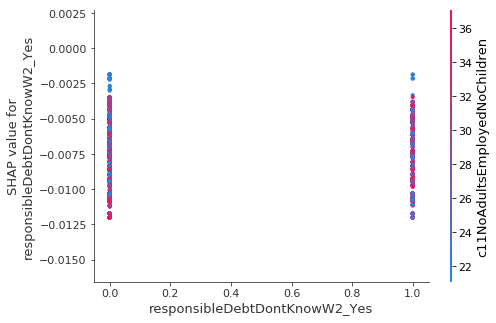

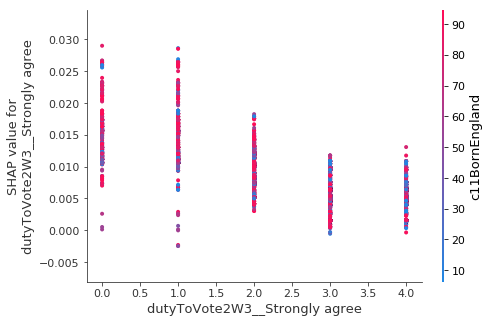

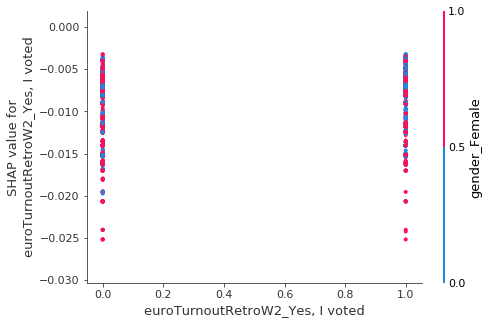

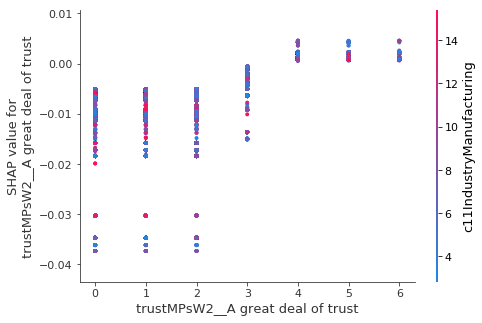

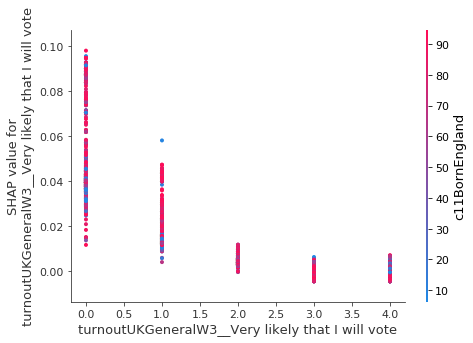

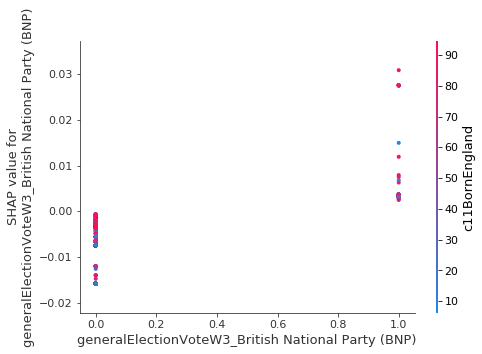

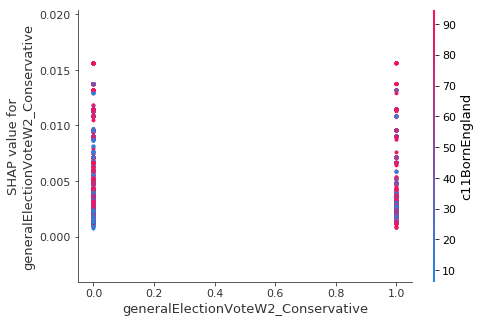

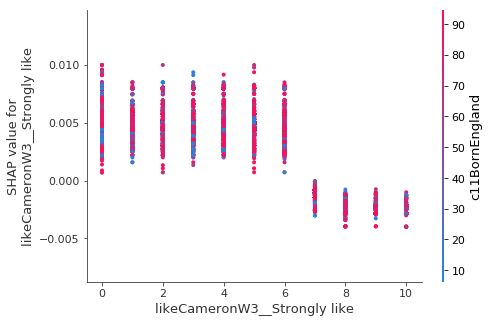

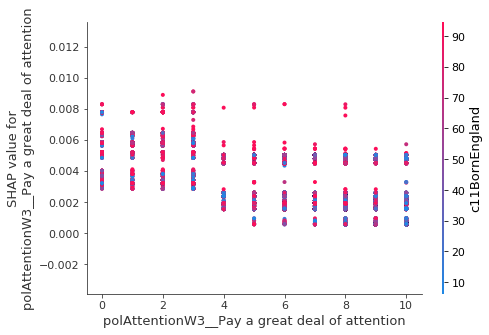

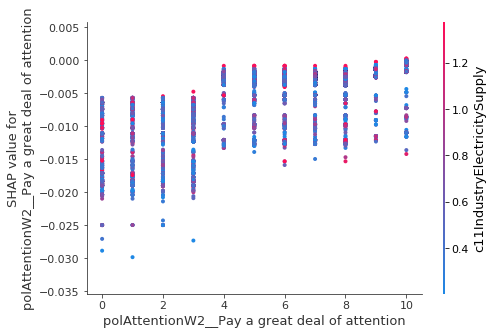

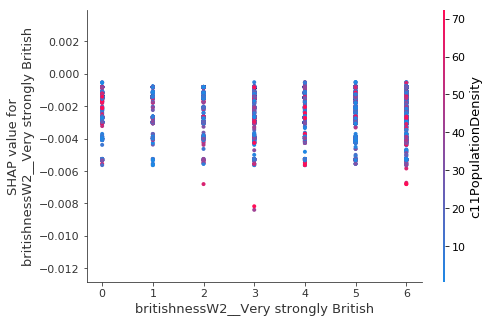

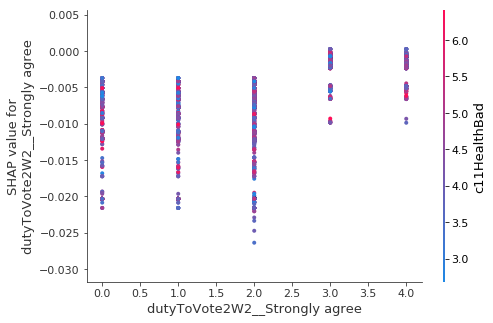

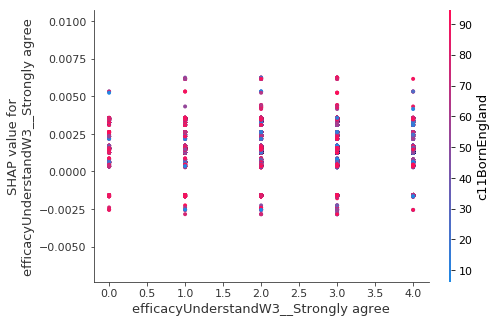

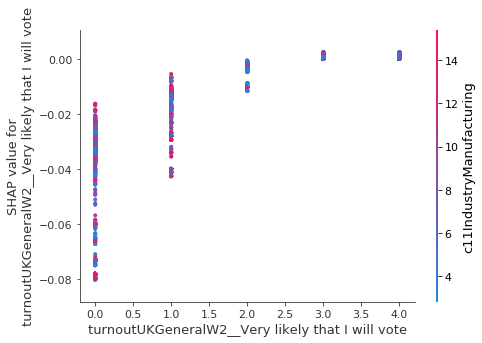

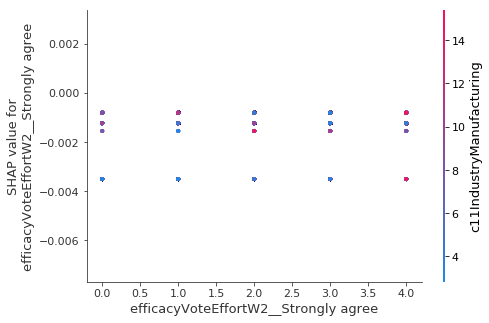

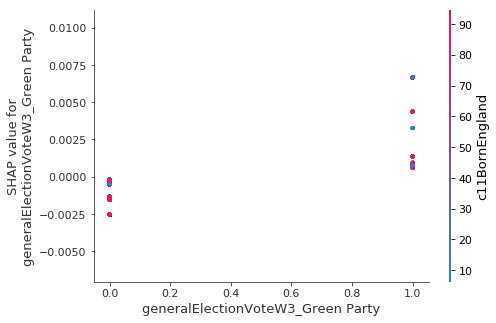

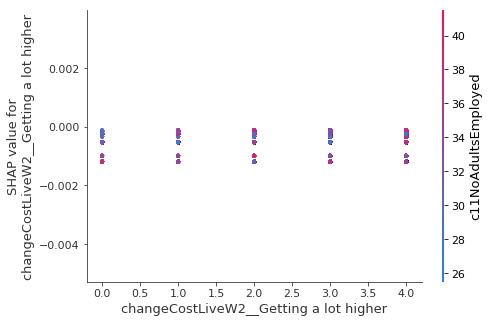

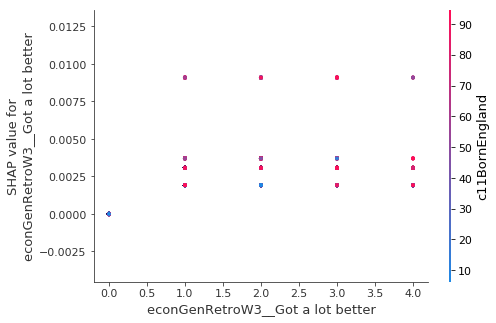

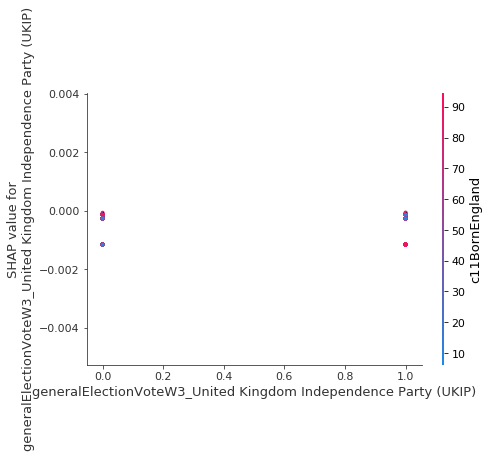

partyIdW4_No - none 4
missing vals in sample weights: 37297
[0]	validation_0-rmse:0.539045
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.522406
[2]	validation_0-rmse:0.50663
[3]	validation_0-rmse:0.491449
[4]	validation_0-rmse:0.477136
[5]	validation_0-rmse:0.463446
[6]	validation_0-rmse:0.450662
[7]	validation_0-rmse:0.438457
[8]	validation_0-rmse:0.426868
[9]	validation_0-rmse:0.416002
[10]	validation_0-rmse:0.405716
[11]	validation_0-rmse:0.395983
[12]	validation_0-rmse:0.386714
[13]	validation_0-rmse:0.378012
[14]	validation_0-rmse:0.369732
[15]	validation_0-rmse:0.362048
[16]	validation_0-rmse:0.354716
[17]	validation_0-rmse:0.347831
[18]	validation_0-rmse:0.341404
[19]	validation_0-rmse:0.335409
MSE: 0.11, MAE: 0.28, EV: 0.08, R2: -0.57


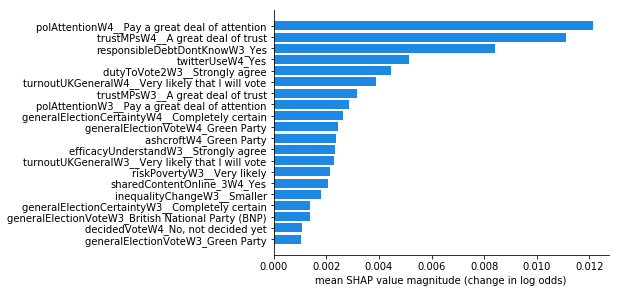

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


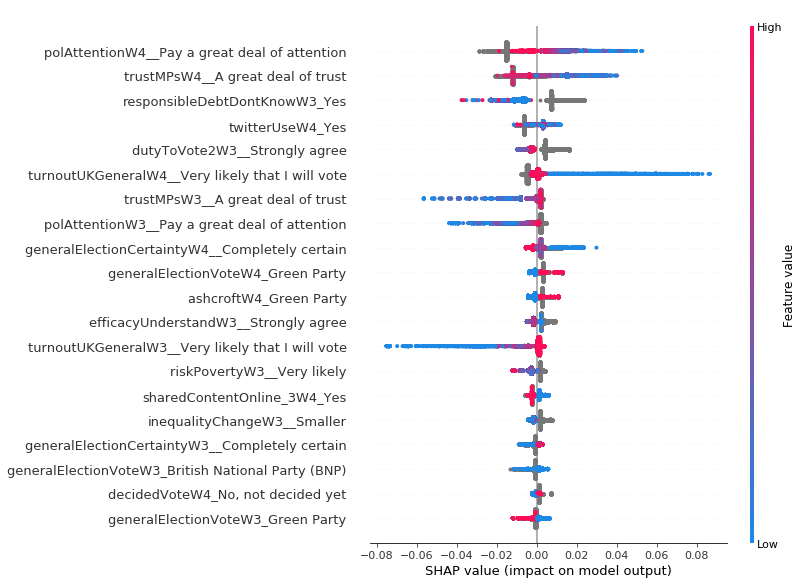

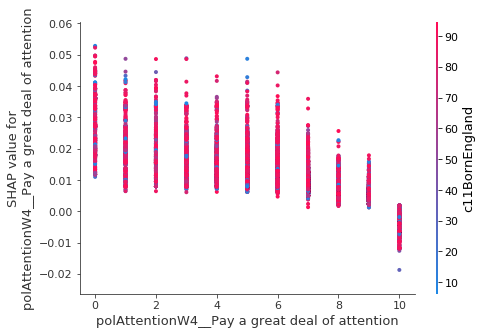

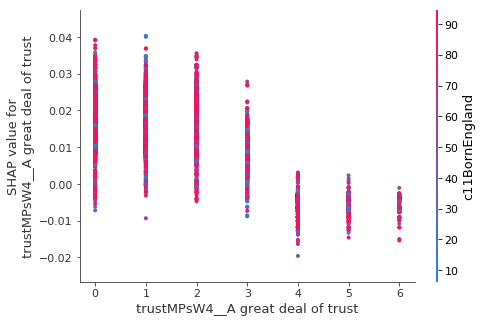

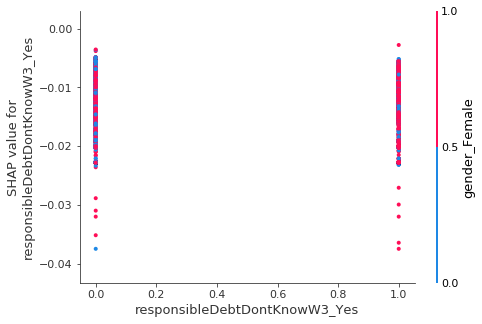

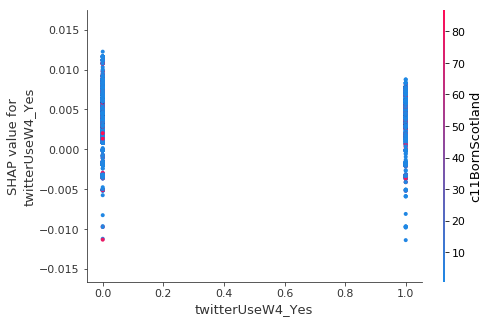

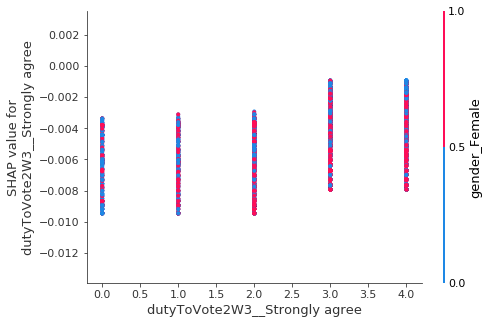

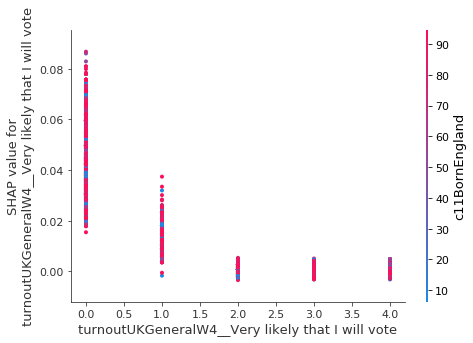

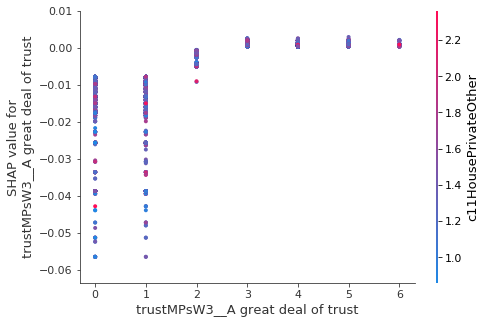

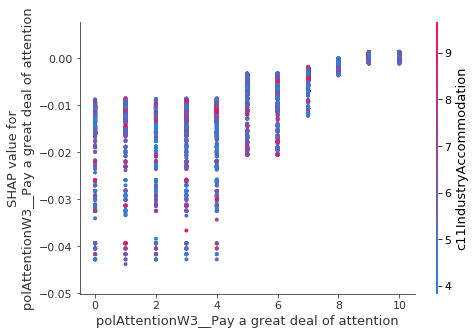

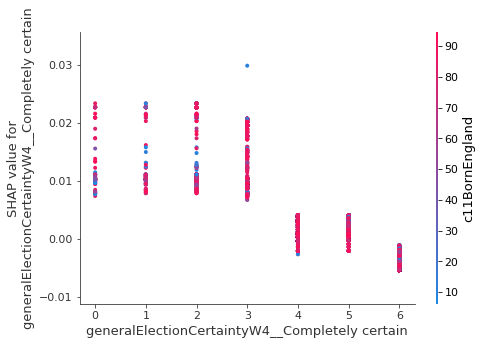

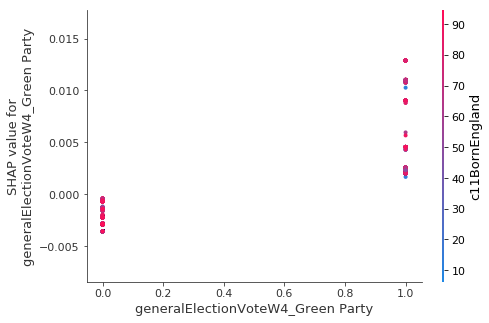

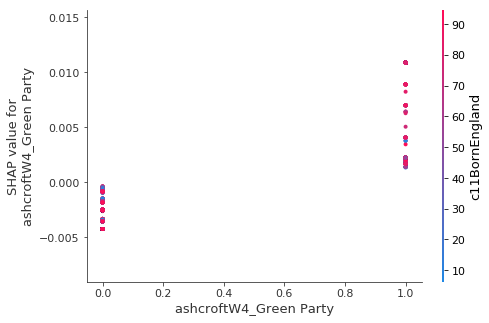

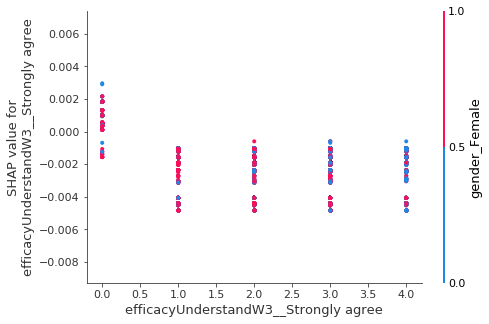

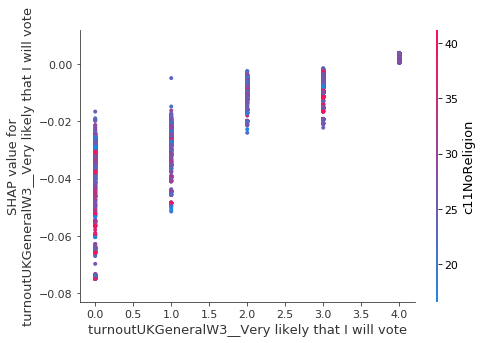

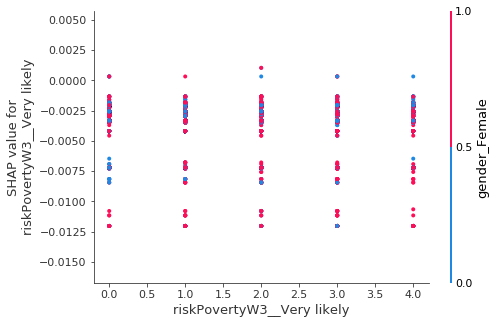

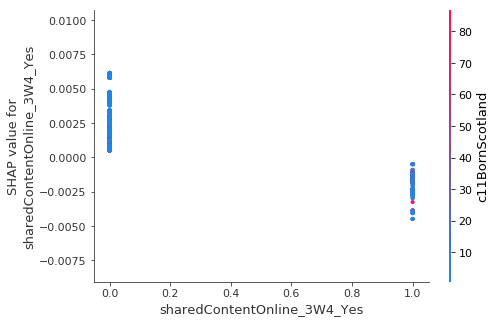

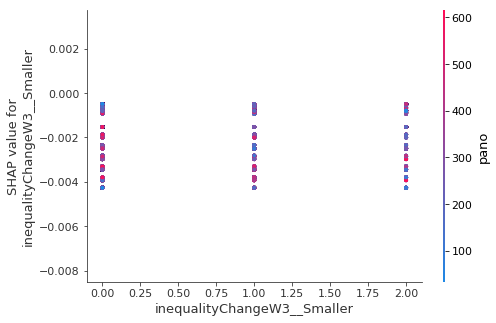

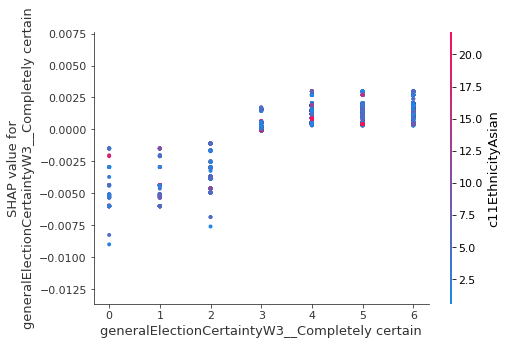

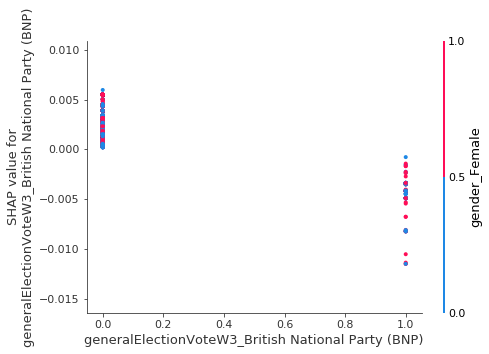

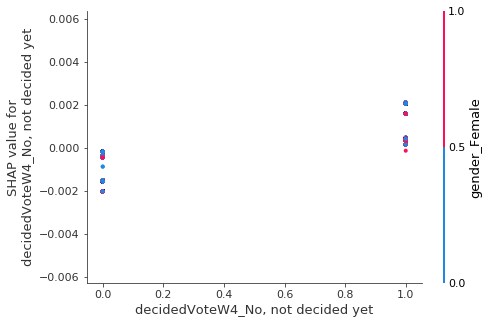

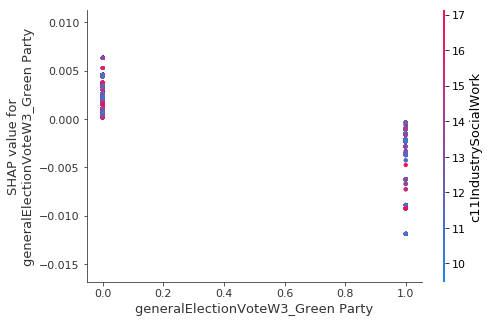

partyIdW6_No - none 6
missing vals in sample weights: 38552
[0]	validation_0-rmse:0.553206
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.5356
[2]	validation_0-rmse:0.518826
[3]	validation_0-rmse:0.502825
[4]	validation_0-rmse:0.487634
[5]	validation_0-rmse:0.473183
[6]	validation_0-rmse:0.459444
[7]	validation_0-rmse:0.44649
[8]	validation_0-rmse:0.43419
[9]	validation_0-rmse:0.422487
[10]	validation_0-rmse:0.411379
[11]	validation_0-rmse:0.401
[12]	validation_0-rmse:0.391102
[13]	validation_0-rmse:0.381778
[14]	validation_0-rmse:0.372913
[15]	validation_0-rmse:0.364633
[16]	validation_0-rmse:0.356763
[17]	validation_0-rmse:0.34941
[18]	validation_0-rmse:0.342463
[19]	validation_0-rmse:0.335919
MSE: 0.11, MAE: 0.27, EV: 0.04, R2: -0.77


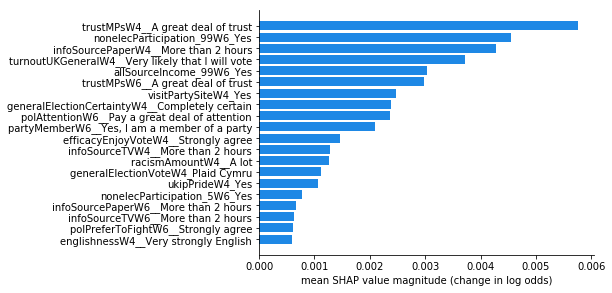

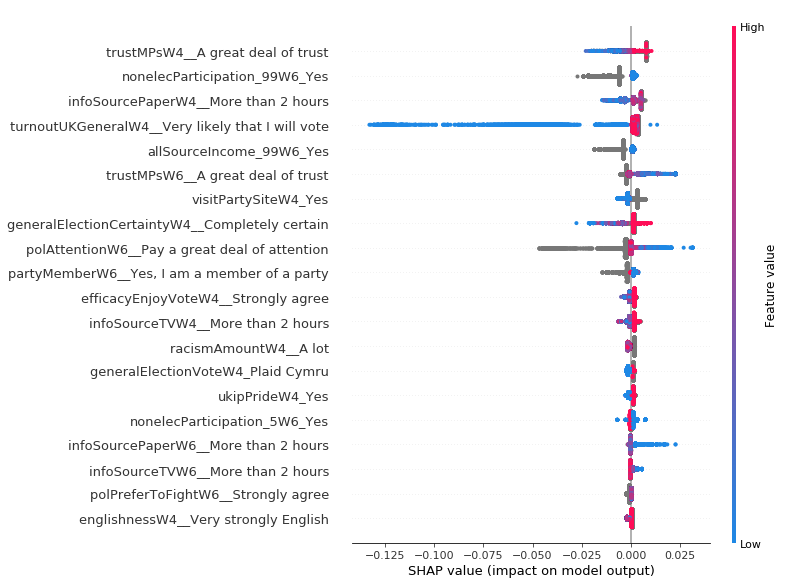

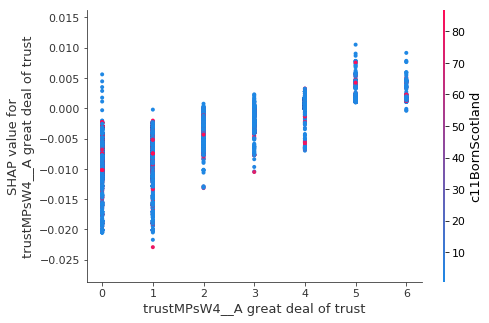

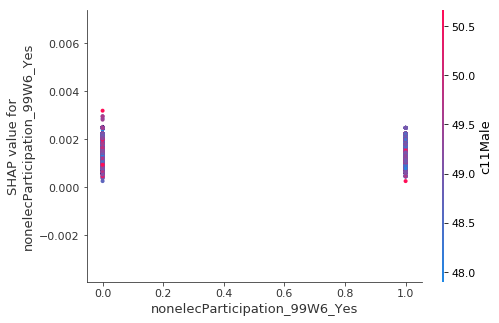

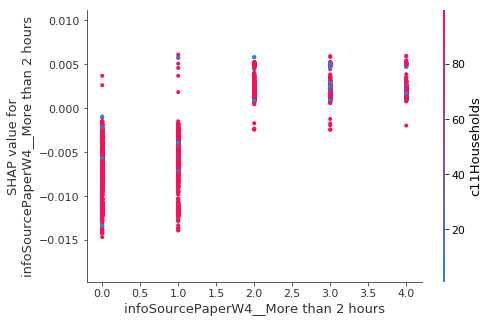

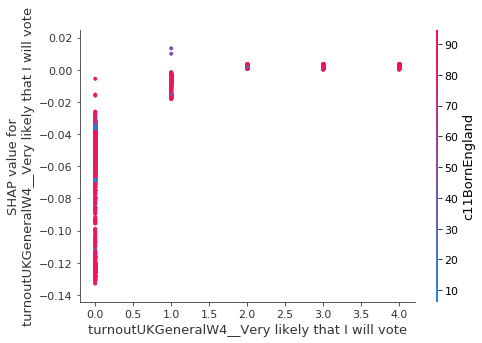

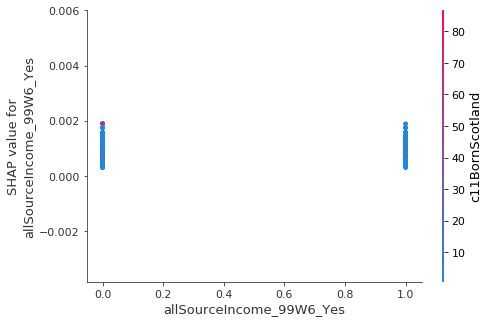

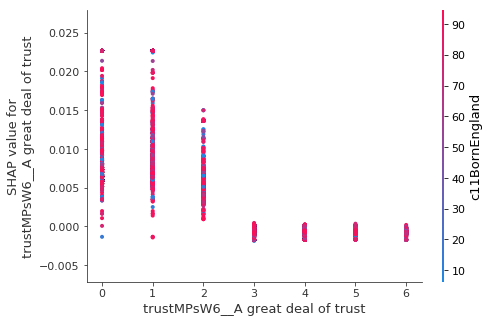

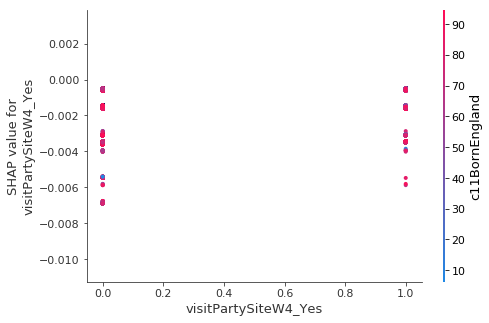

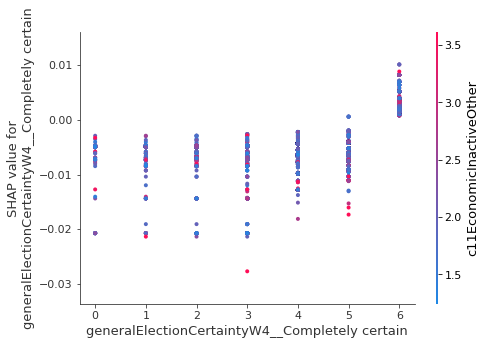

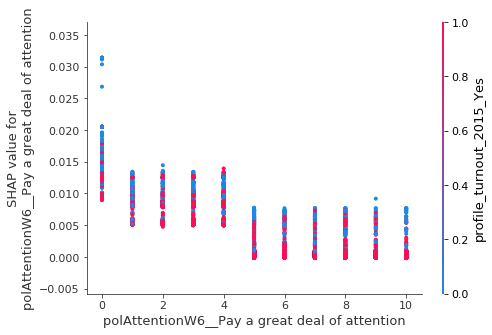

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


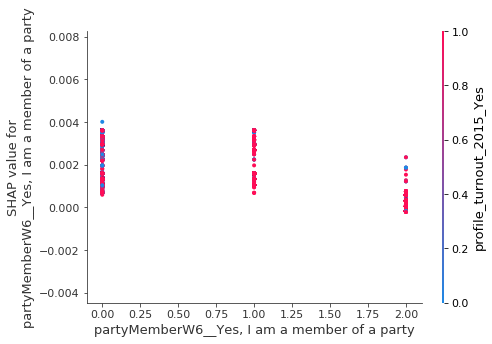

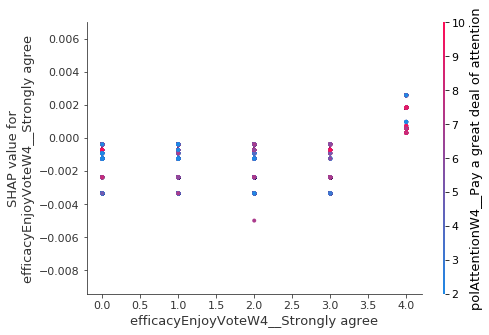

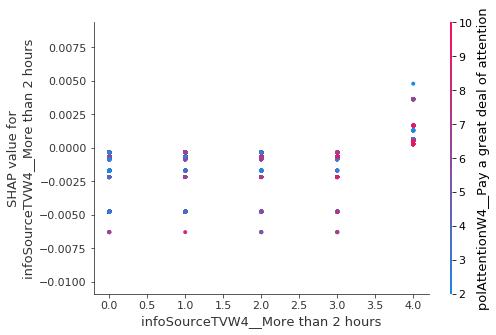

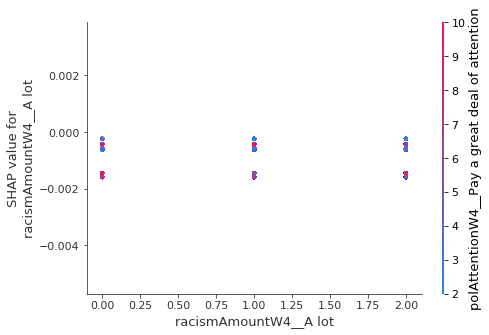

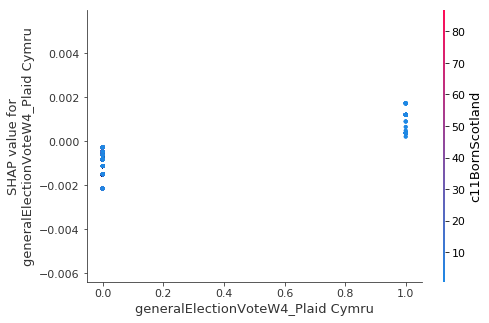

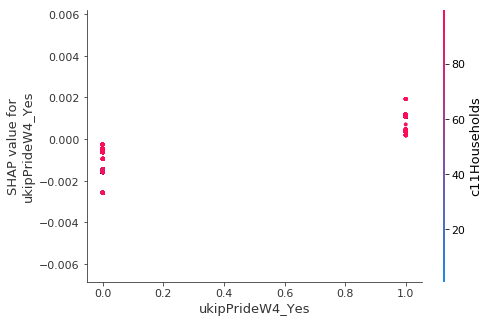

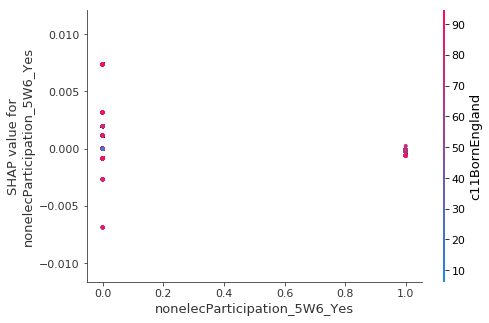

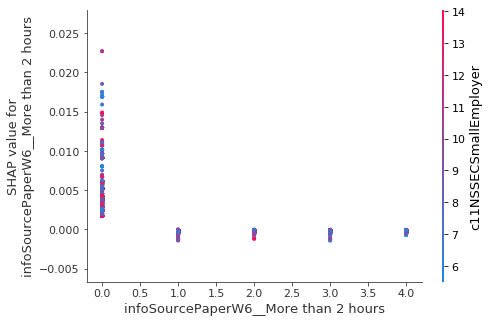

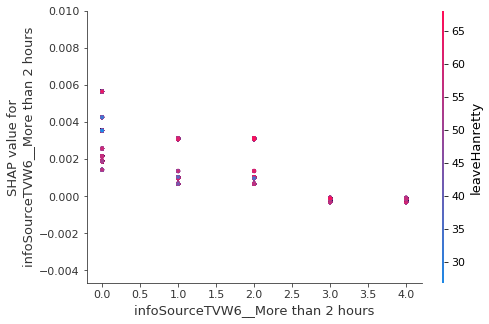

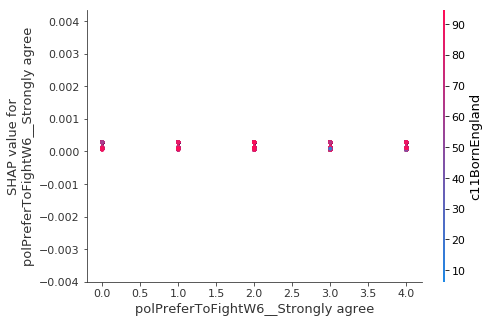

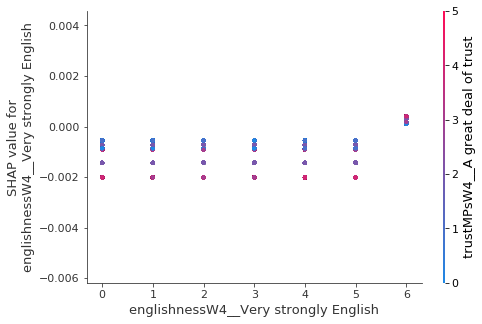

partyIdW7_No - none 7
missing vals in sample weights: 37730
[0]	validation_0-rmse:0.548709
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.531885
[2]	validation_0-rmse:0.515747
[3]	validation_0-rmse:0.500441
[4]	validation_0-rmse:0.485923
[5]	validation_0-rmse:0.47213
[6]	validation_0-rmse:0.459091
[7]	validation_0-rmse:0.446661
[8]	validation_0-rmse:0.434994
[9]	validation_0-rmse:0.423809
[10]	validation_0-rmse:0.413308
[11]	validation_0-rmse:0.403407
[12]	validation_0-rmse:0.394094
[13]	validation_0-rmse:0.385334
[14]	validation_0-rmse:0.377122
[15]	validation_0-rmse:0.369251
[16]	validation_0-rmse:0.361954
[17]	validation_0-rmse:0.355049
[18]	validation_0-rmse:0.348544
[19]	validation_0-rmse:0.342531
MSE: 0.12, MAE: 0.28, EV: 0.09, R2: -0.50


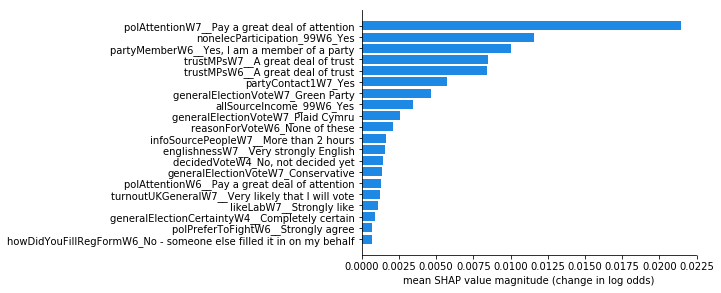

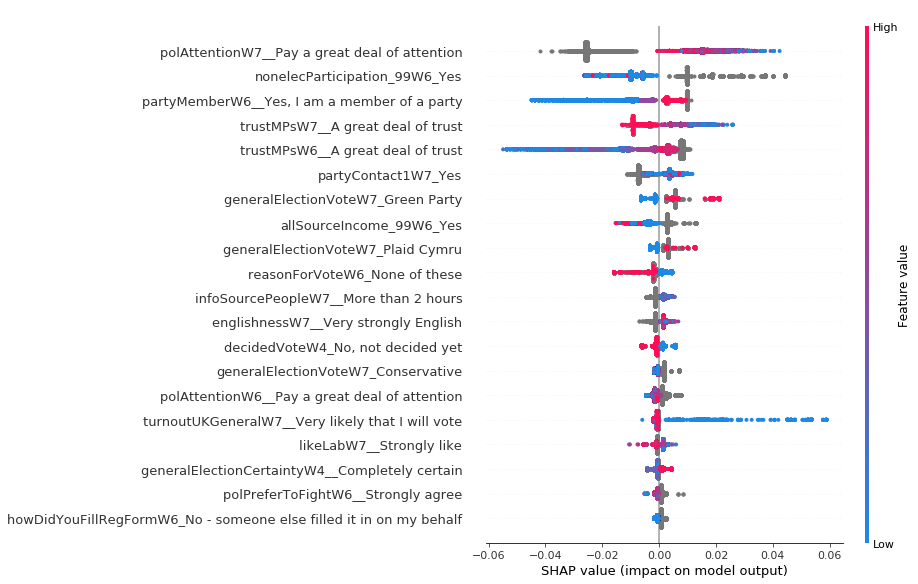

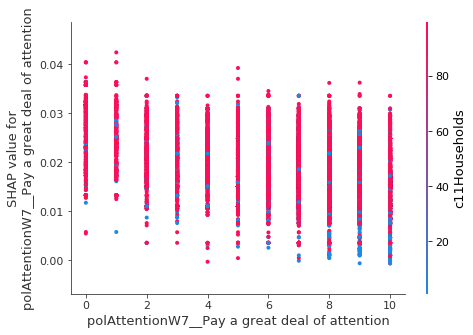

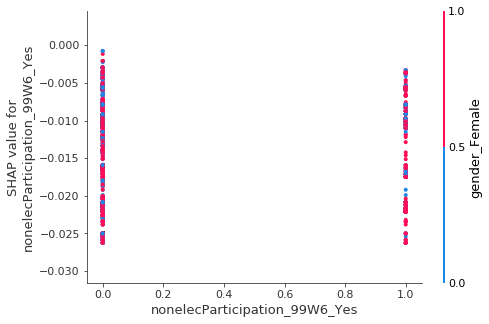

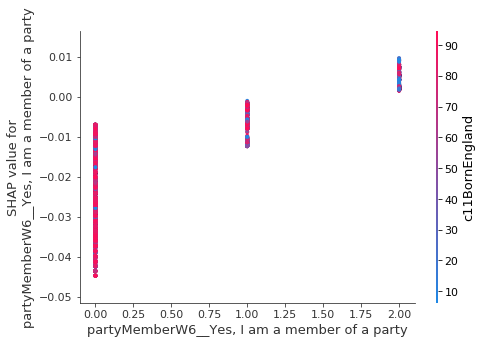

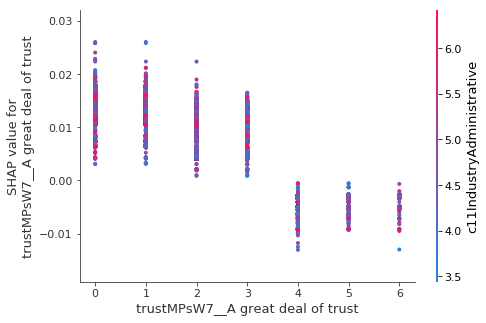

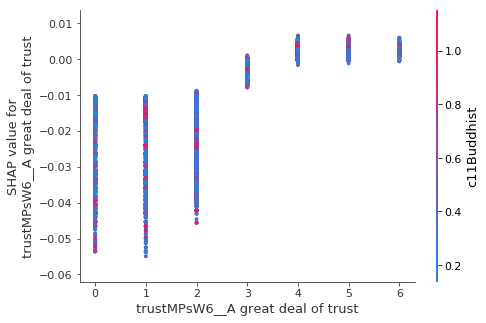

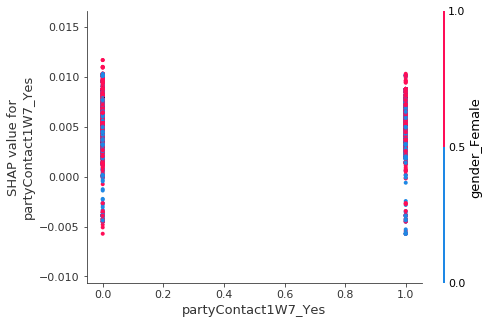

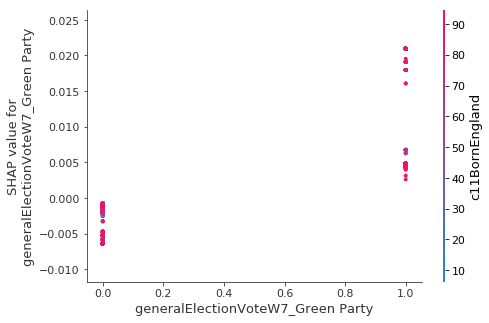

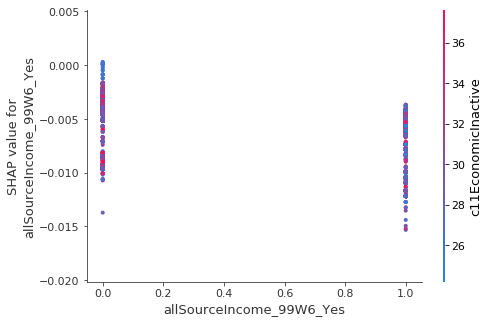

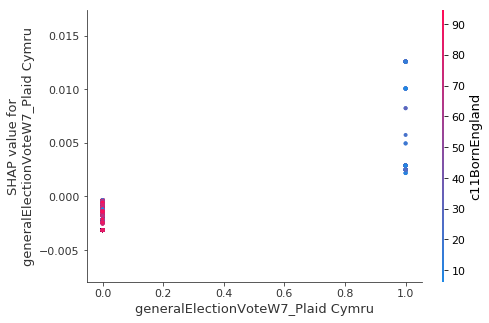

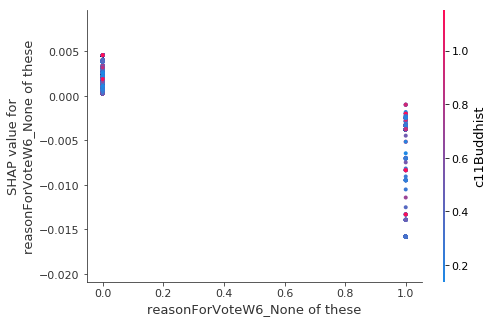

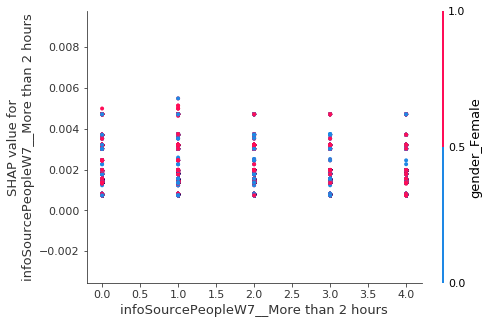

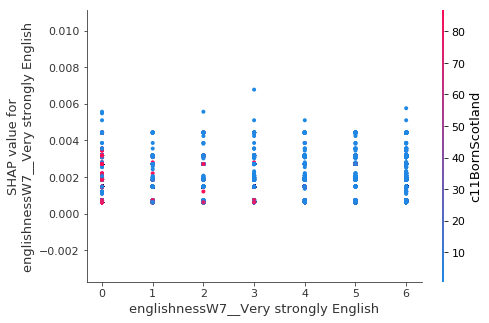

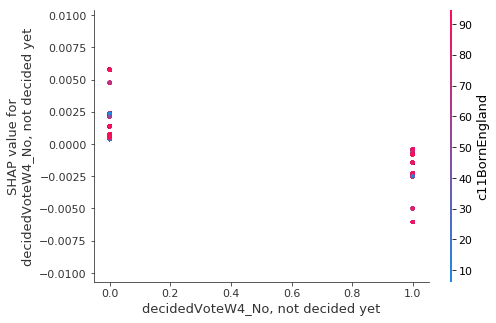

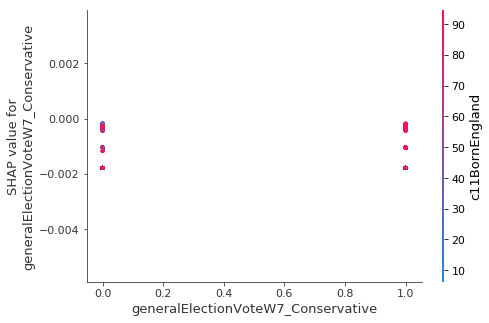

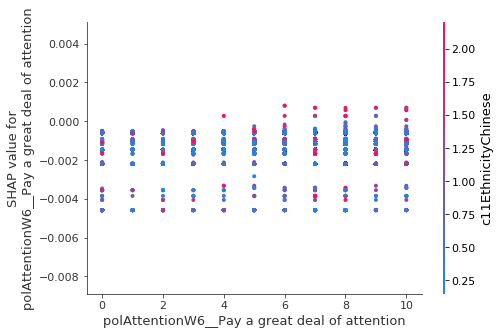

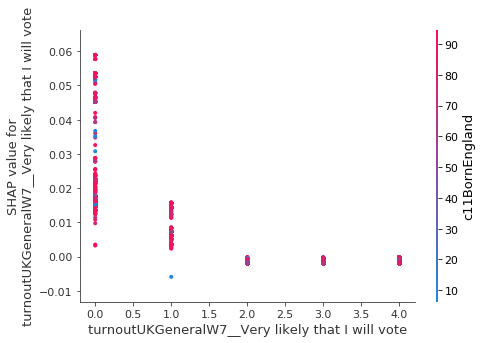

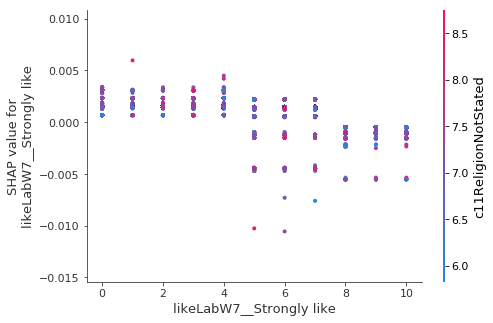

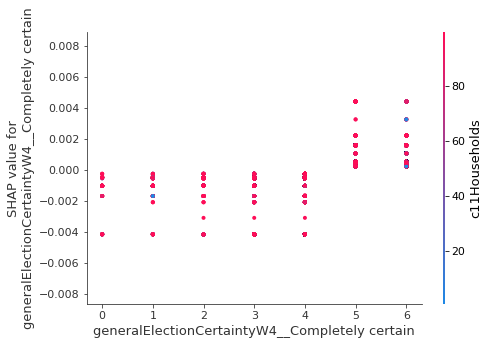

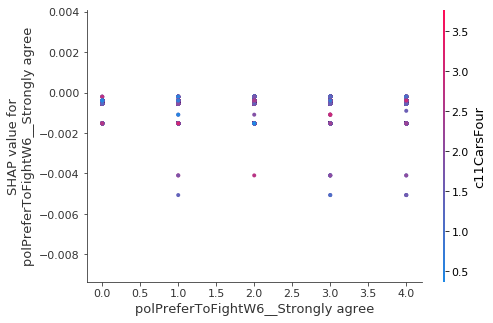

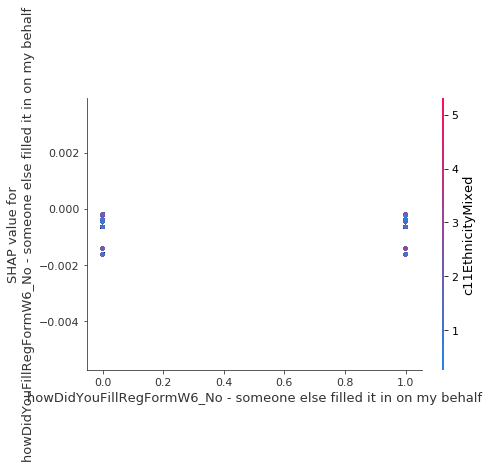

partyIdW8_No - none 8
missing vals in sample weights: 35123
[0]	validation_0-rmse:0.543091
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.526117
[2]	validation_0-rmse:0.51002
[3]	validation_0-rmse:0.494672
[4]	validation_0-rmse:0.480004
[5]	validation_0-rmse:0.466116
[6]	validation_0-rmse:0.452943
[7]	validation_0-rmse:0.440448
[8]	validation_0-rmse:0.428584
[9]	validation_0-rmse:0.417401
[10]	validation_0-rmse:0.406784
[11]	validation_0-rmse:0.396757
[12]	validation_0-rmse:0.387218
[13]	validation_0-rmse:0.378295
[14]	validation_0-rmse:0.369849
[15]	validation_0-rmse:0.361921
[16]	validation_0-rmse:0.354422
[17]	validation_0-rmse:0.34736
[18]	validation_0-rmse:0.340784
[19]	validation_0-rmse:0.334555
MSE: 0.11, MAE: 0.27, EV: 0.08, R2: -0.61


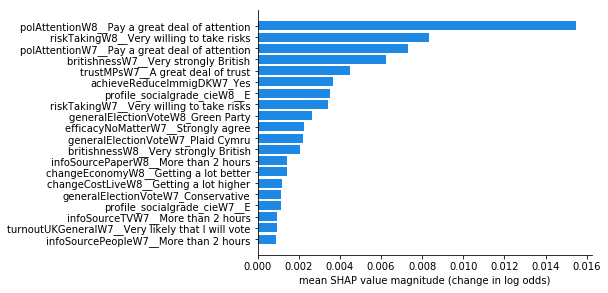

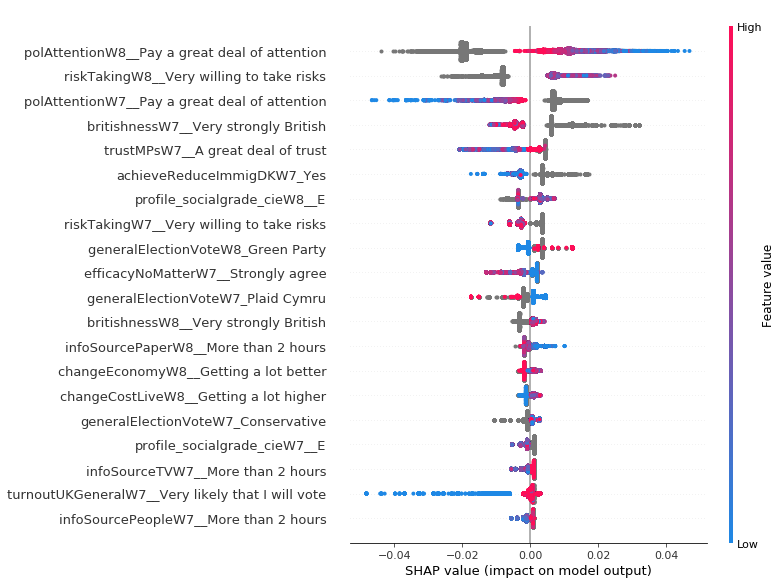

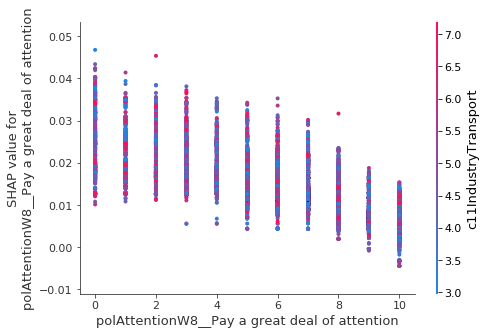

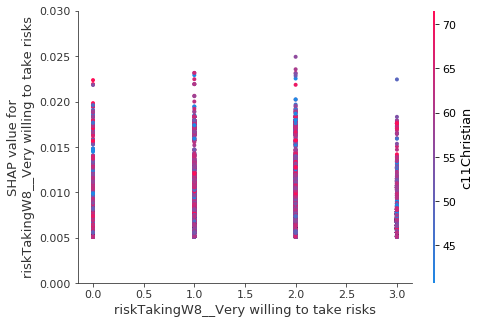

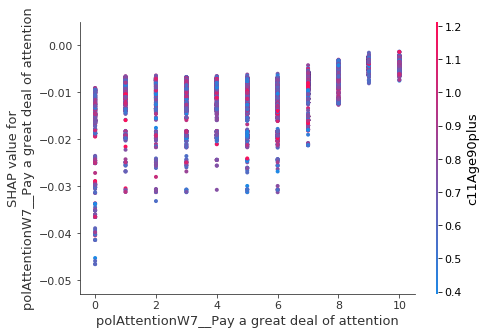

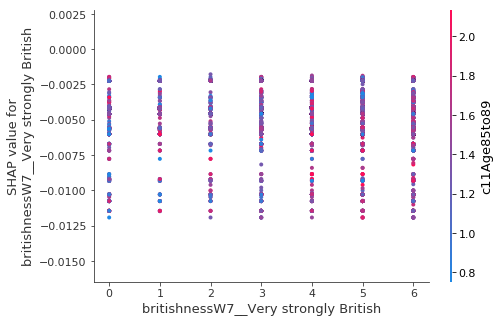

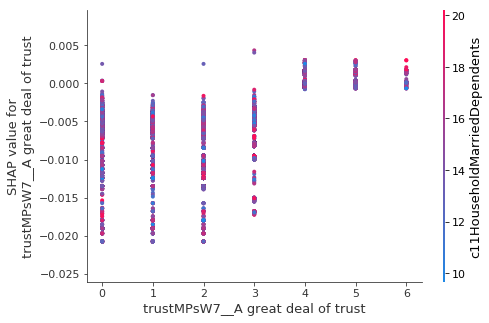

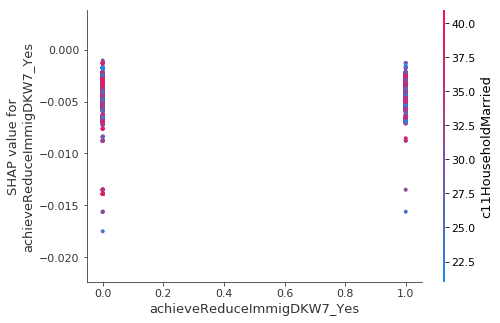

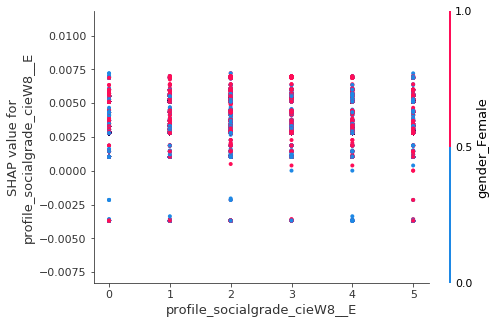

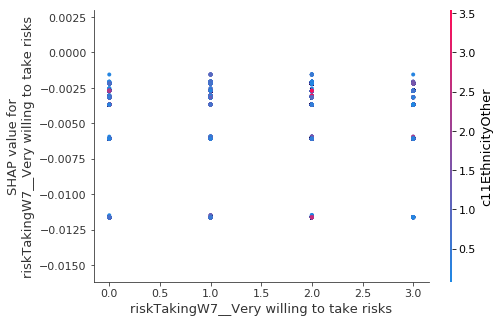

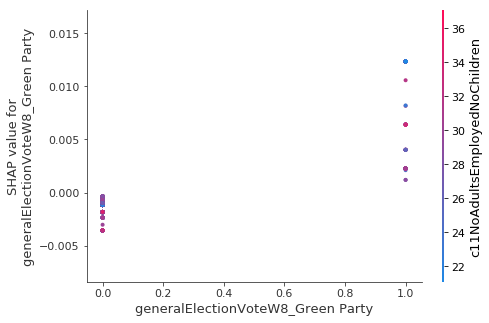

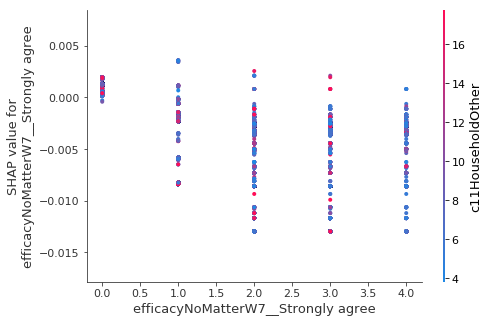

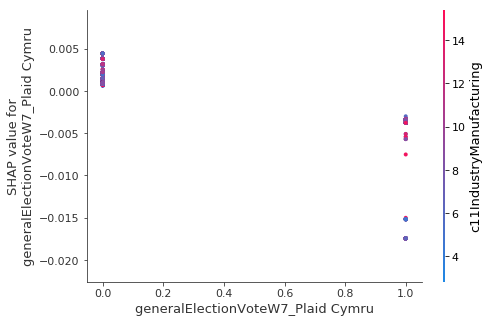

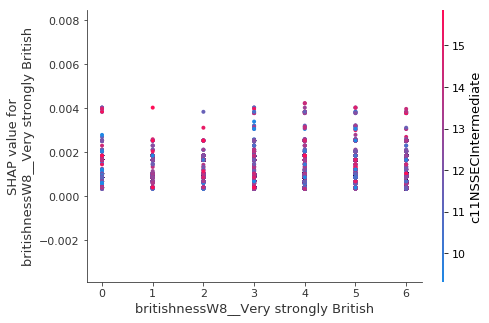

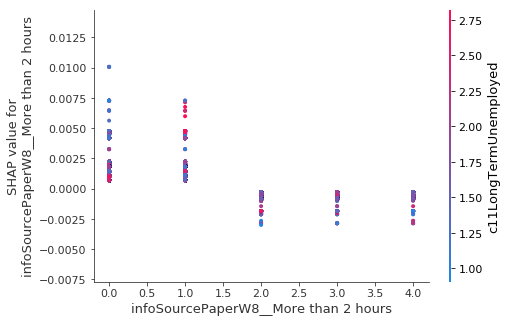

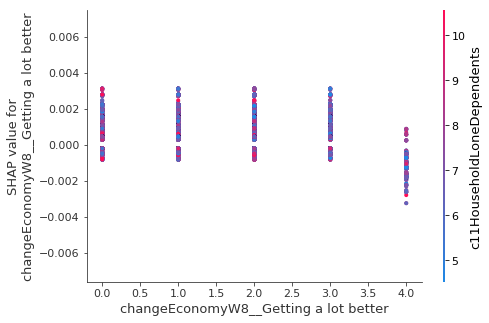

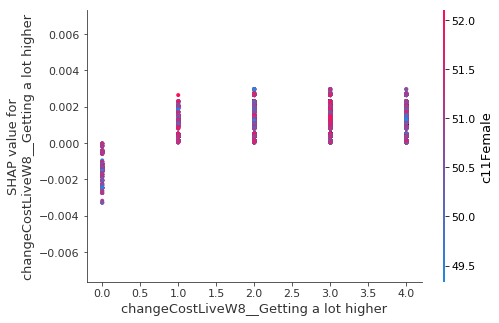

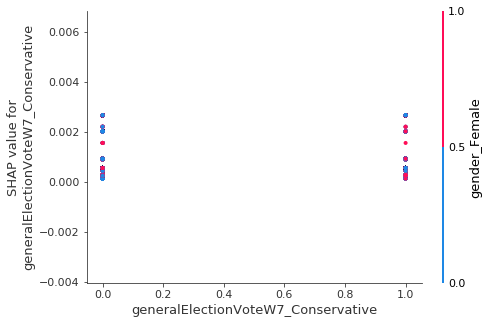

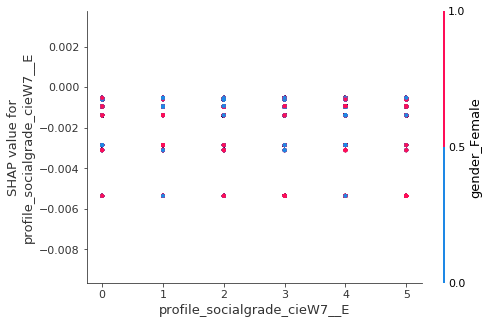

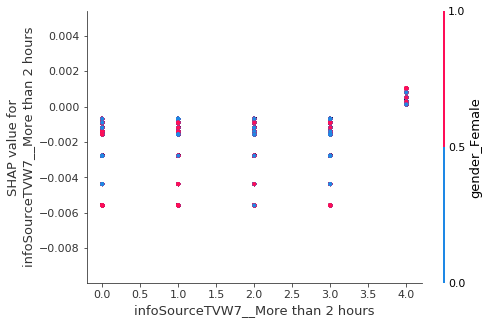

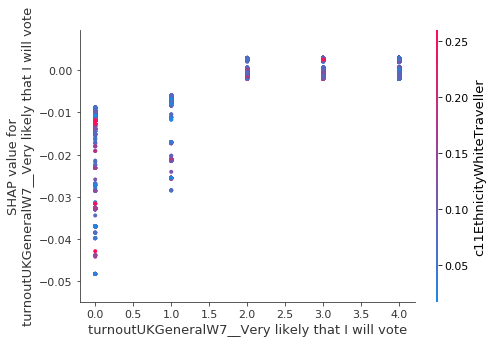

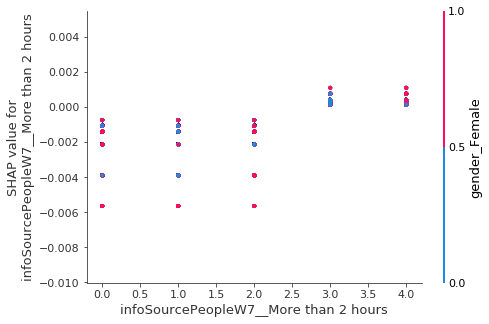

partyIdW9_No - none 9
missing vals in sample weights: 38589
[0]	validation_0-rmse:0.542765
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.525148
[2]	validation_0-rmse:0.508416
[3]	validation_0-rmse:0.492567
[4]	validation_0-rmse:0.477474
[5]	validation_0-rmse:0.463075
[6]	validation_0-rmse:0.449403
[7]	validation_0-rmse:0.436451
[8]	validation_0-rmse:0.424122
[9]	validation_0-rmse:0.412407
[10]	validation_0-rmse:0.401423
[11]	validation_0-rmse:0.390939
[12]	validation_0-rmse:0.380915
[13]	validation_0-rmse:0.371512
[14]	validation_0-rmse:0.362563
[15]	validation_0-rmse:0.354176
[16]	validation_0-rmse:0.346287
[17]	validation_0-rmse:0.338926
[18]	validation_0-rmse:0.331949
[19]	validation_0-rmse:0.32527
MSE: 0.11, MAE: 0.26, EV: 0.05, R2: -0.81


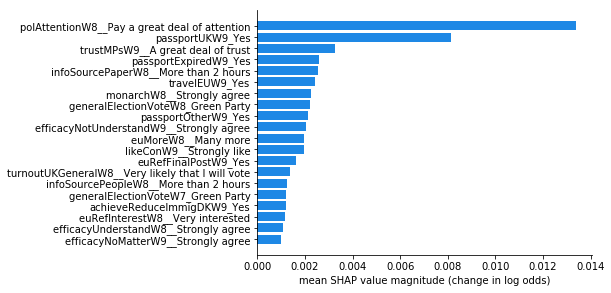

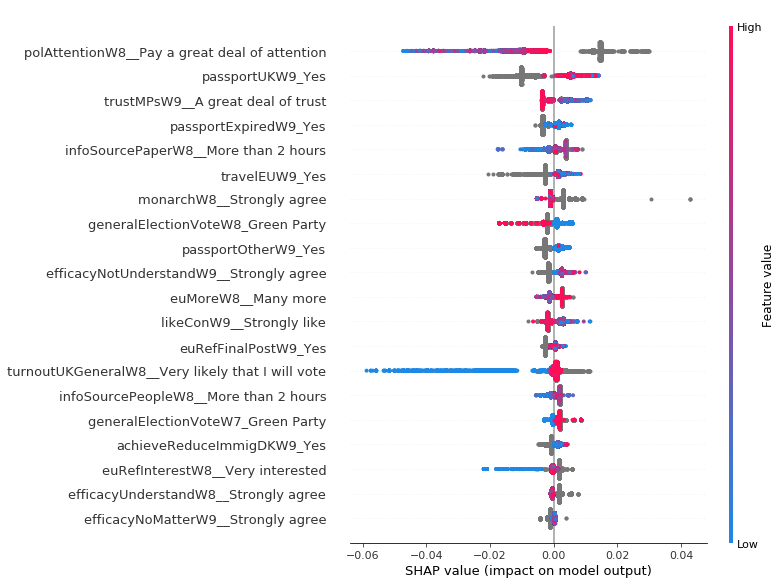

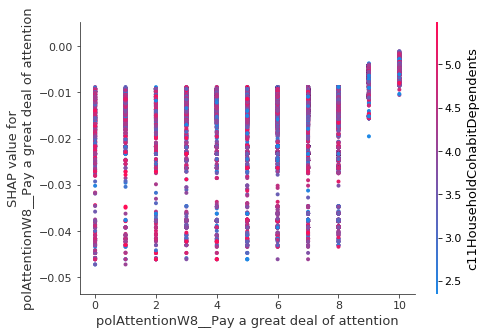

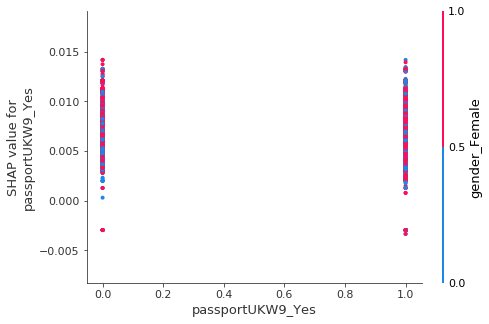

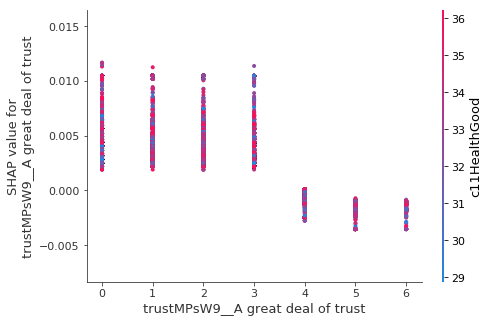

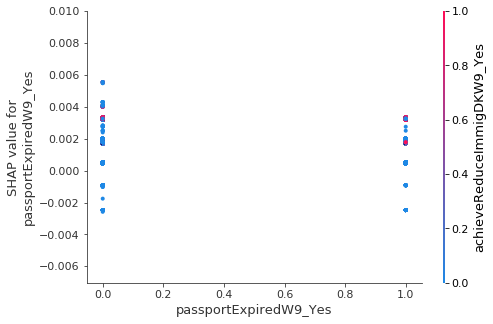

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


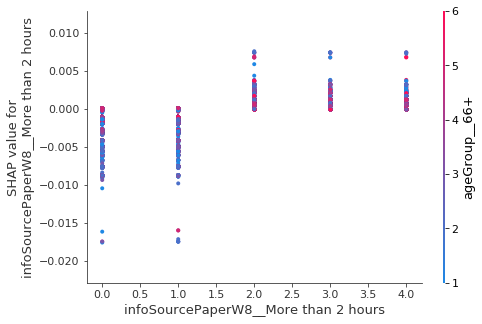

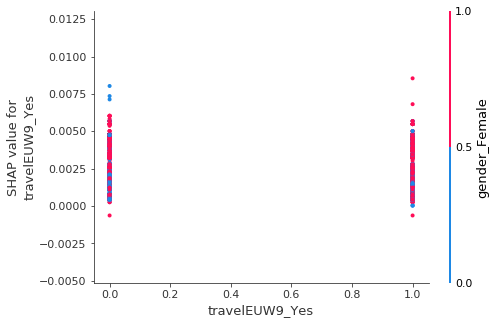

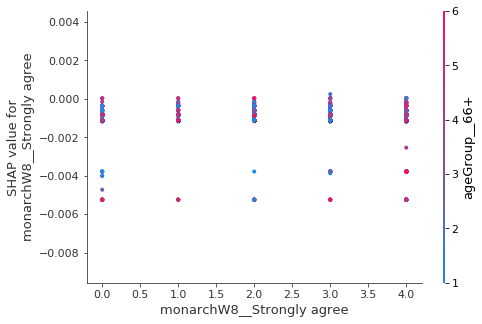

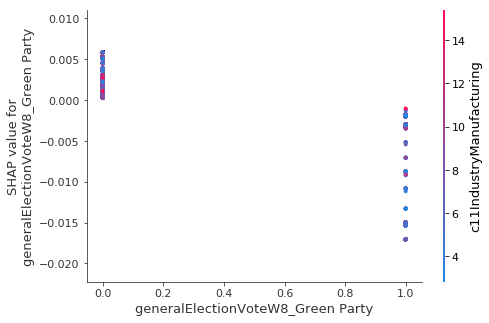

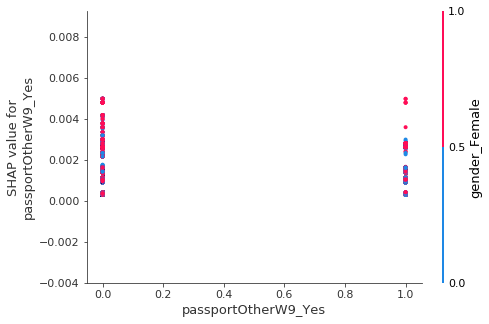

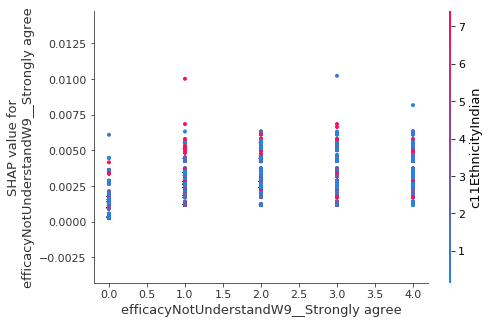

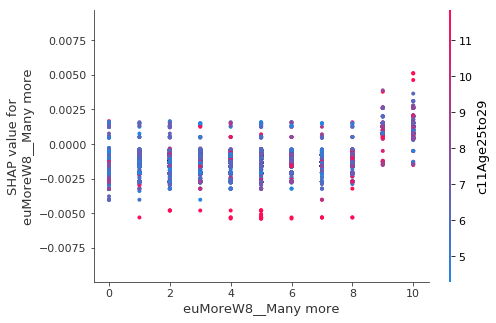

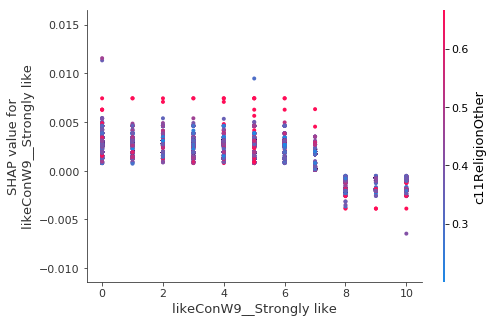

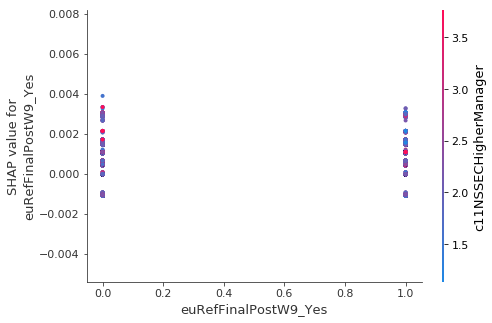

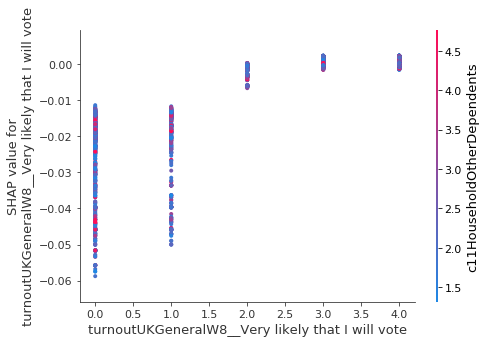

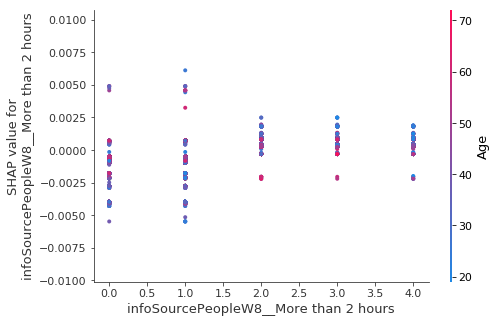

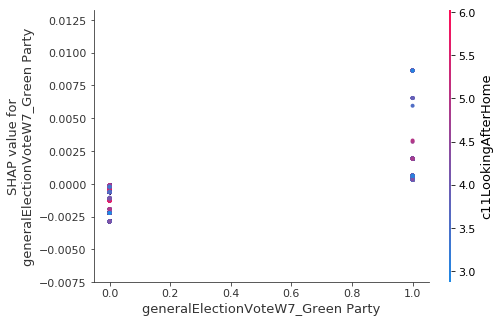

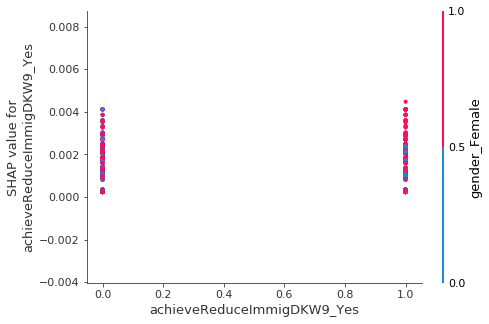

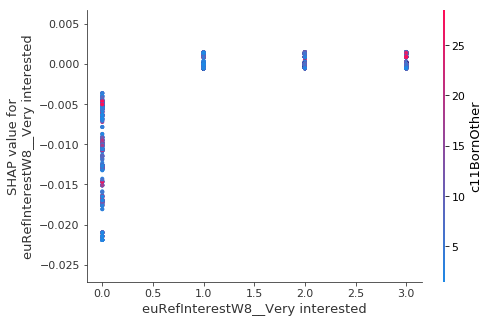

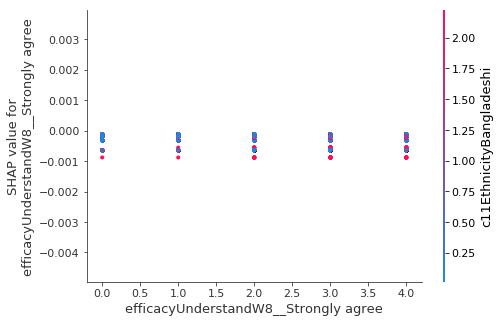

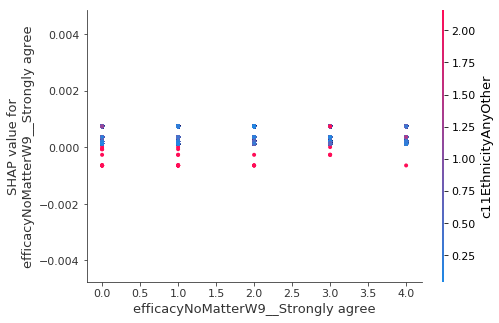

partyIdW10_No - none 10
missing vals in sample weights: 38306
[0]	validation_0-rmse:0.552206
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.535636
[2]	validation_0-rmse:0.519734
[3]	validation_0-rmse:0.50473
[4]	validation_0-rmse:0.490488
[5]	validation_0-rmse:0.476902
[6]	validation_0-rmse:0.46402
[7]	validation_0-rmse:0.45175
[8]	validation_0-rmse:0.440254
[9]	validation_0-rmse:0.429323
[10]	validation_0-rmse:0.418959
[11]	validation_0-rmse:0.409144
[12]	validation_0-rmse:0.399934
[13]	validation_0-rmse:0.3913
[14]	validation_0-rmse:0.38318
[15]	validation_0-rmse:0.375537
[16]	validation_0-rmse:0.368252
[17]	validation_0-rmse:0.361481
[18]	validation_0-rmse:0.355093
[19]	validation_0-rmse:0.349092
MSE: 0.12, MAE: 0.28, EV: 0.13, R2: -0.42


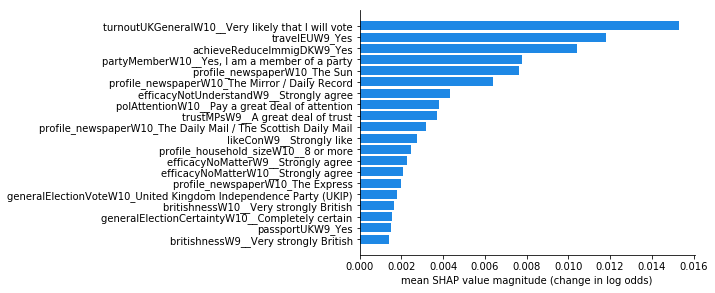

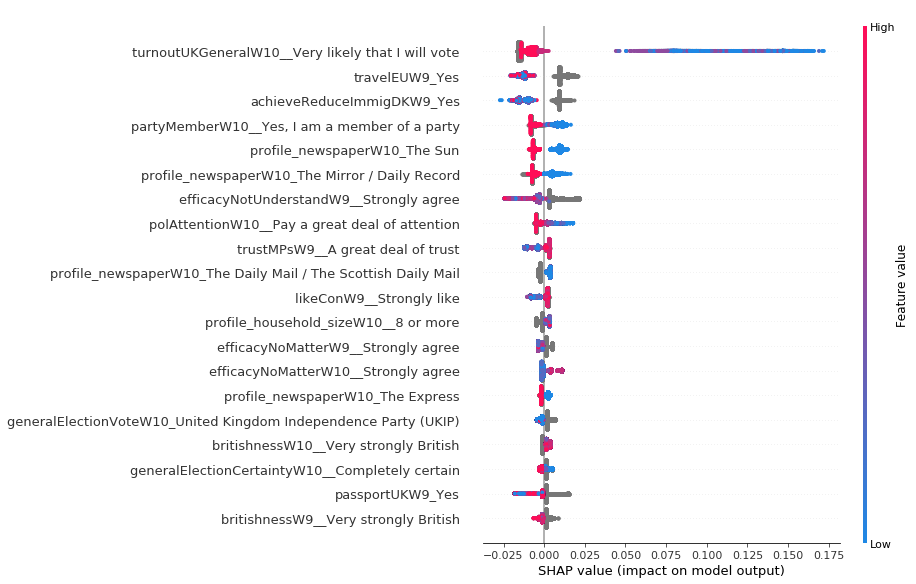

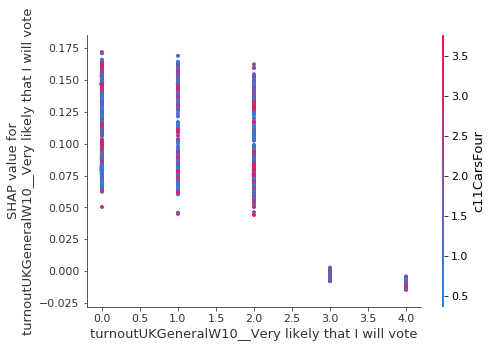

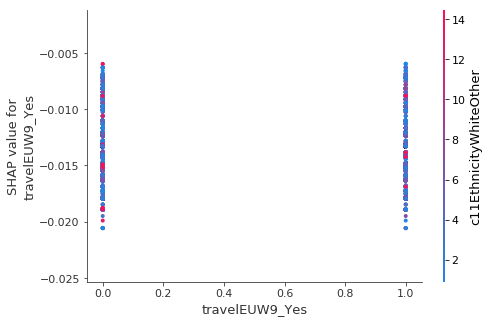

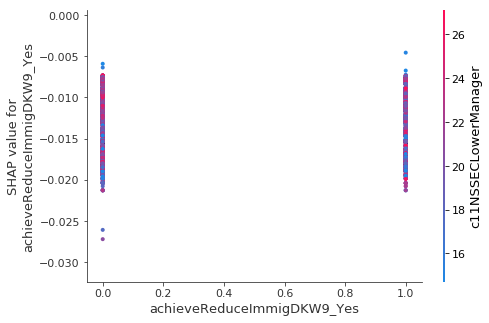

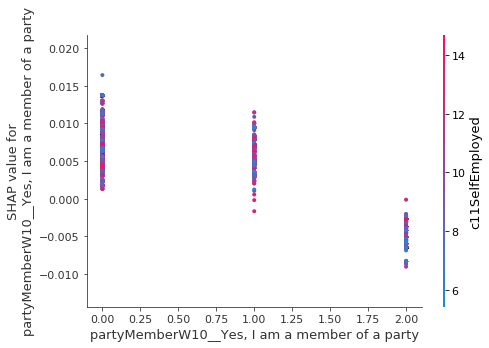

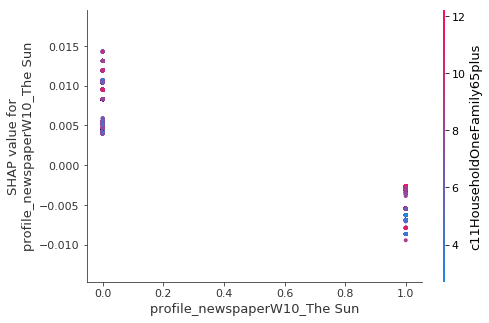

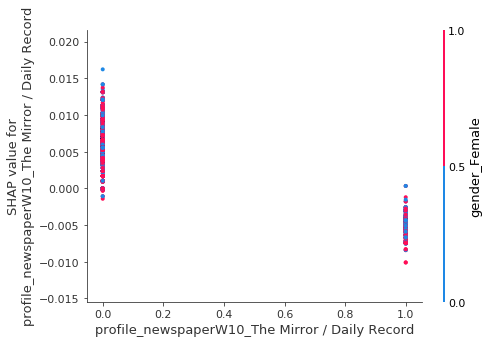

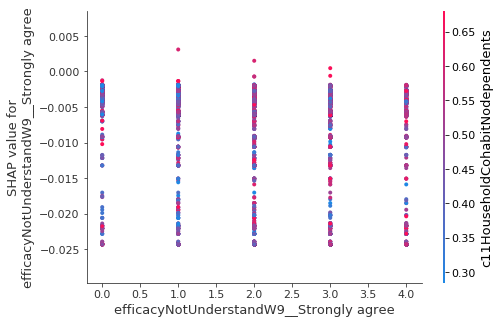

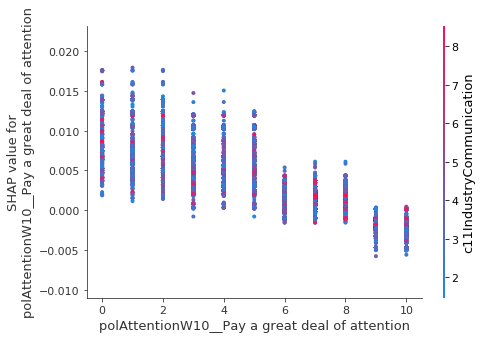

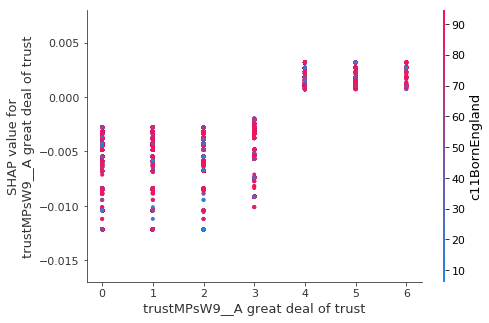

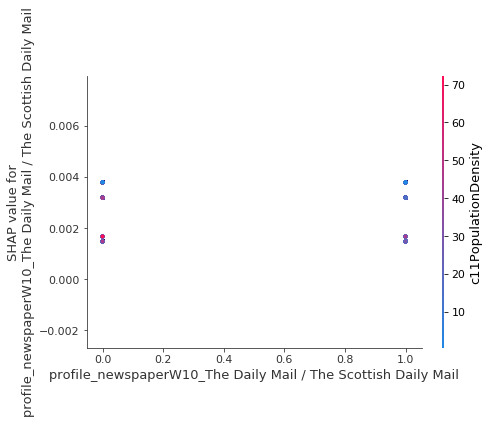

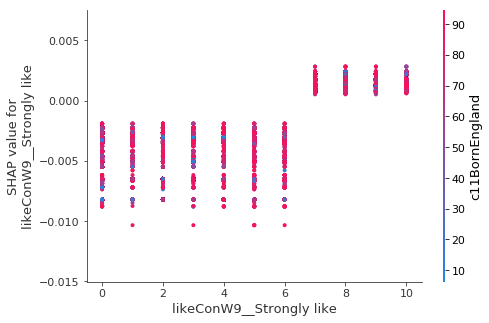

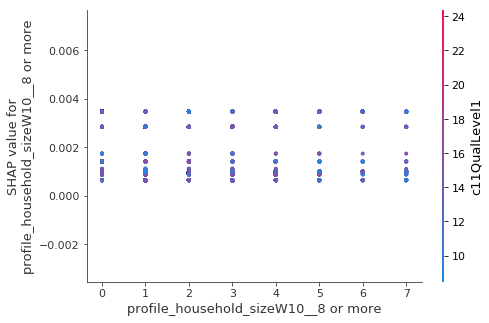

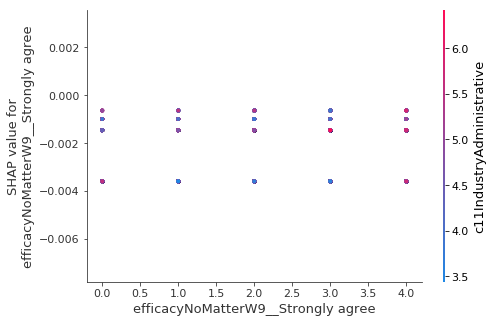

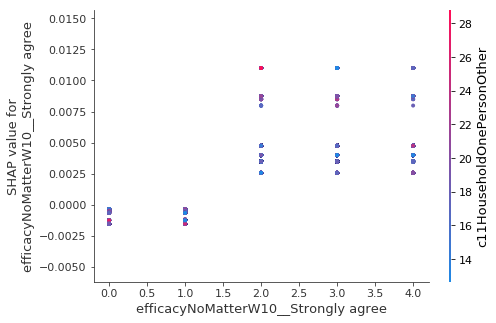

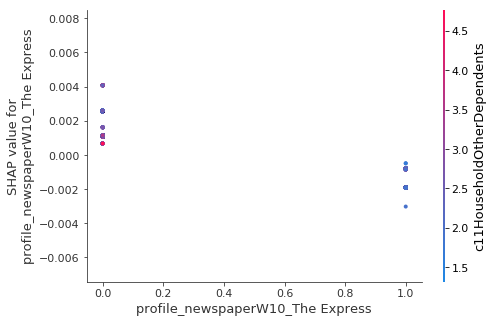

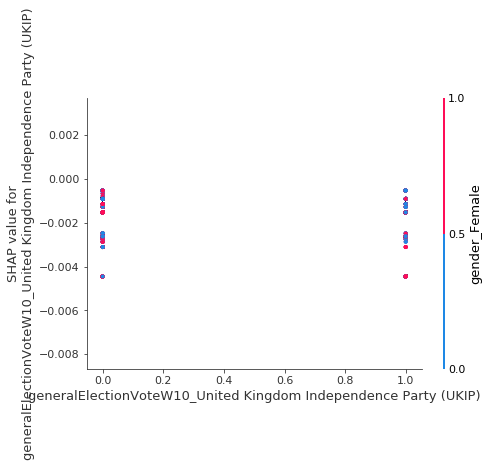

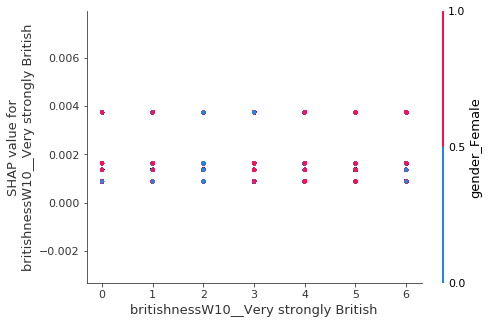

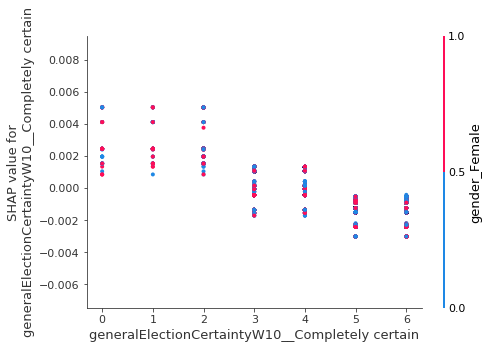

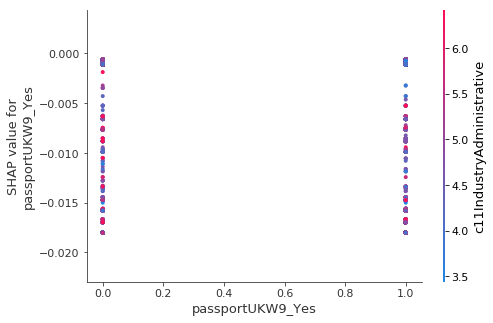

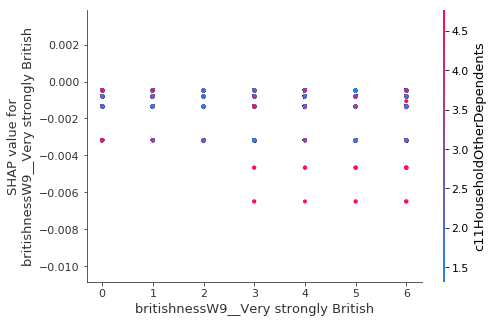

partyIdW11_No - none 11
missing vals in sample weights: 37611
[0]	validation_0-rmse:0.560663
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.54342
[2]	validation_0-rmse:0.527045
[3]	validation_0-rmse:0.511475
[4]	validation_0-rmse:0.496572
[5]	validation_0-rmse:0.482421
[6]	validation_0-rmse:0.469116
[7]	validation_0-rmse:0.456433
[8]	validation_0-rmse:0.444474
[9]	validation_0-rmse:0.433127
[10]	validation_0-rmse:0.422351
[11]	validation_0-rmse:0.412156
[12]	validation_0-rmse:0.402499
[13]	validation_0-rmse:0.393368
[14]	validation_0-rmse:0.384979
[15]	validation_0-rmse:0.376878
[16]	validation_0-rmse:0.369289
[17]	validation_0-rmse:0.362108
[18]	validation_0-rmse:0.355305
[19]	validation_0-rmse:0.348954
MSE: 0.12, MAE: 0.28, EV: 0.12, R2: -0.50


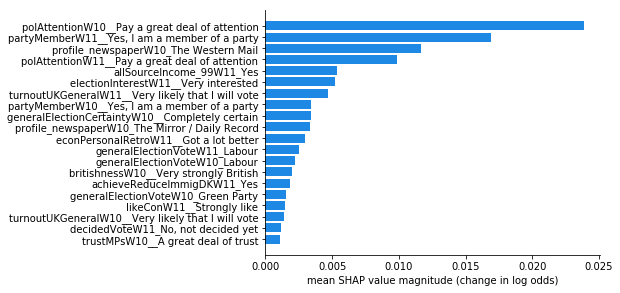

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


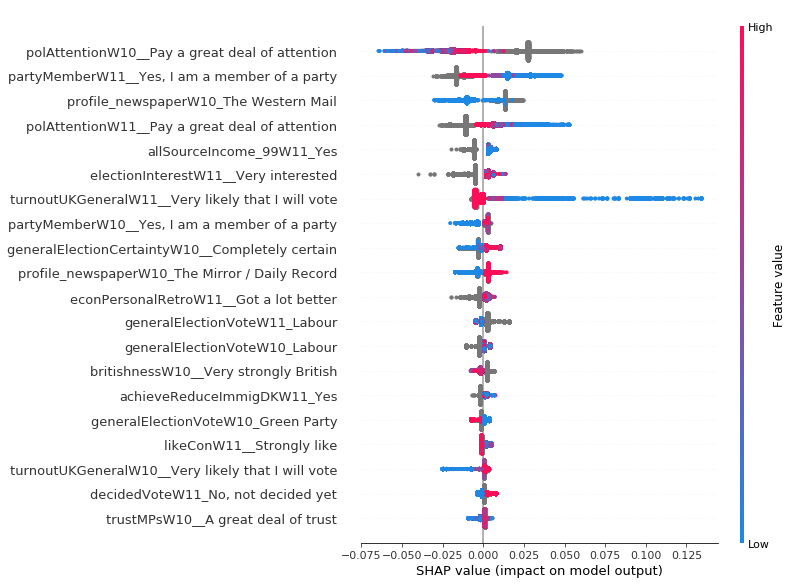

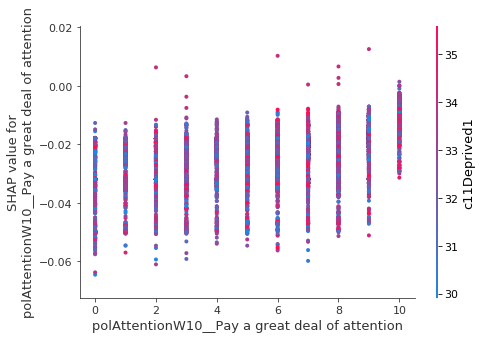

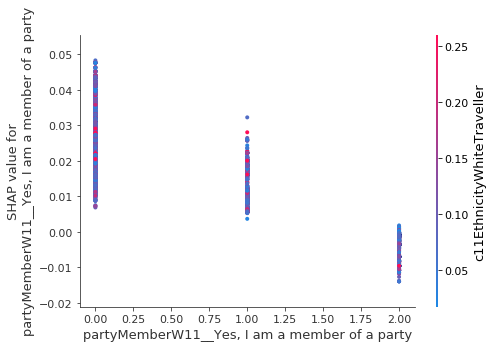

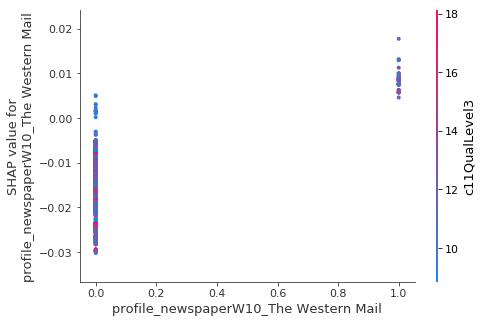

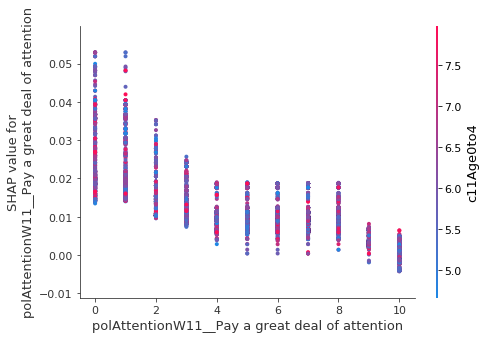

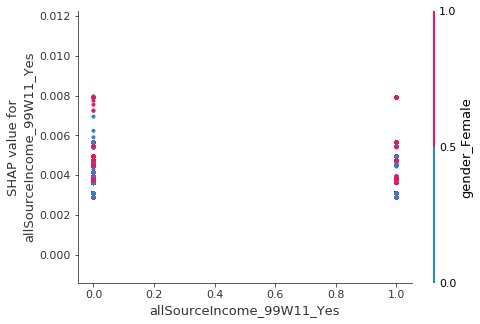

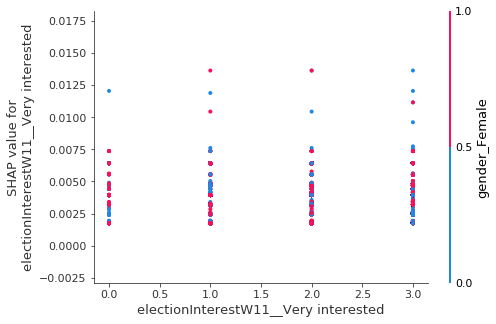

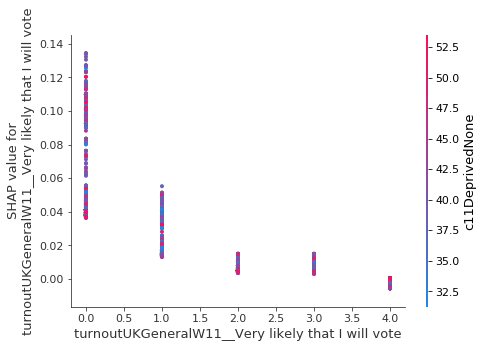

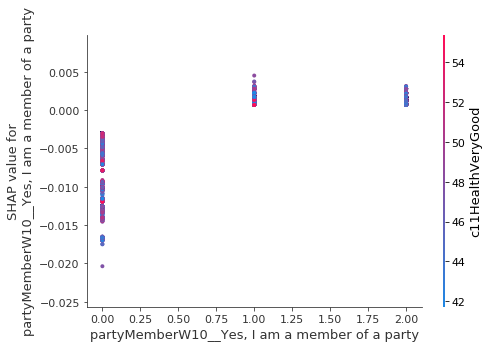

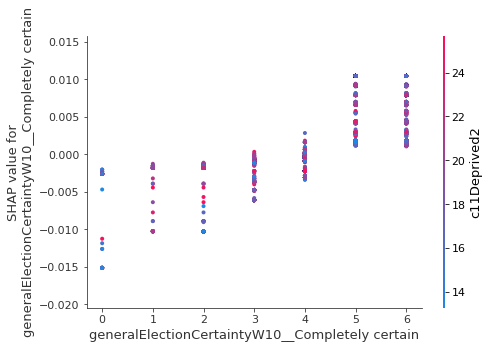

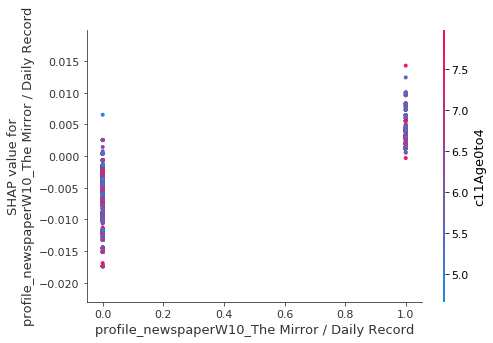

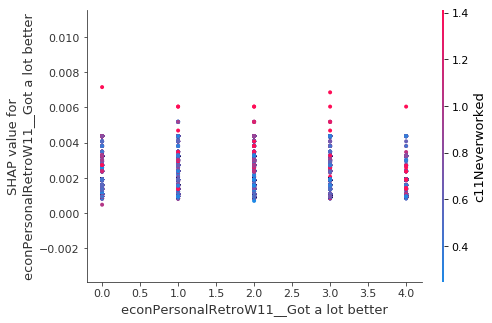

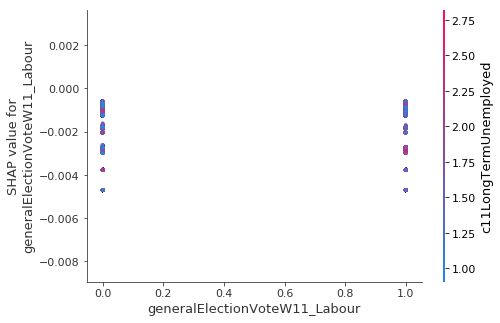

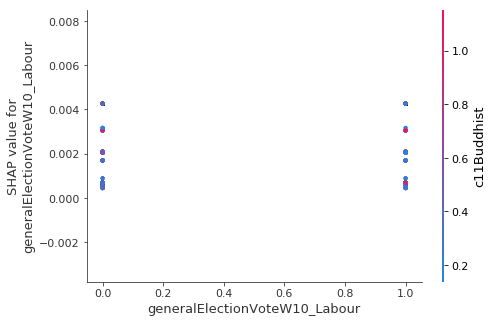

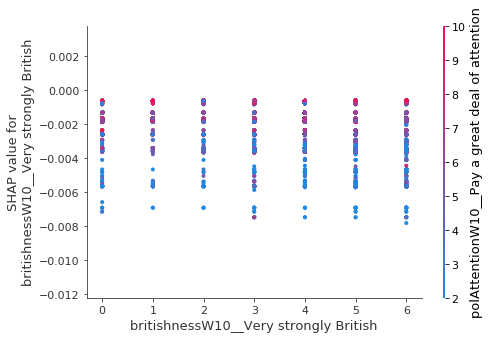

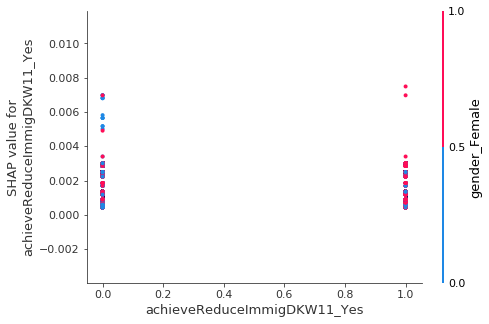

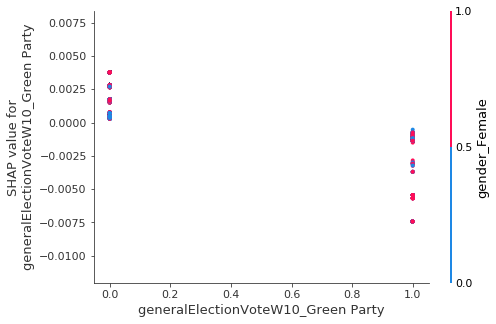

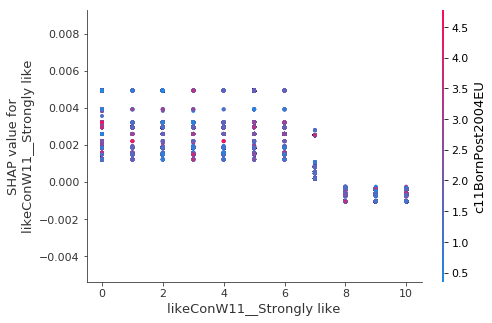

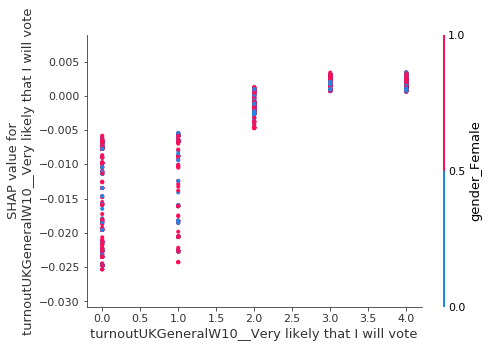

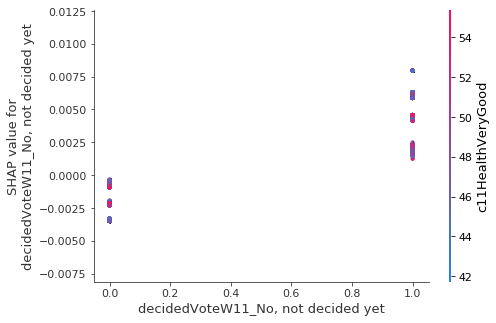

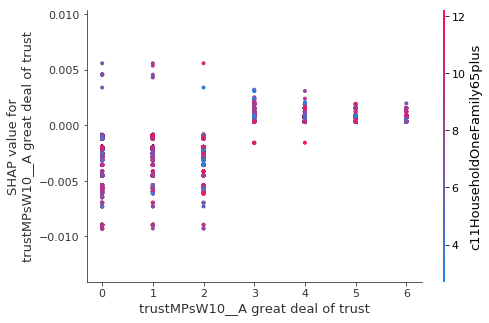

partyIdW12_No - none 12
missing vals in sample weights: 34161
[0]	validation_0-rmse:0.543194
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.526865
[2]	validation_0-rmse:0.511302
[3]	validation_0-rmse:0.496533
[4]	validation_0-rmse:0.482542
[5]	validation_0-rmse:0.469236
[6]	validation_0-rmse:0.456656
[7]	validation_0-rmse:0.444714
[8]	validation_0-rmse:0.433323
[9]	validation_0-rmse:0.422461
[10]	validation_0-rmse:0.412403
[11]	validation_0-rmse:0.402835
[12]	validation_0-rmse:0.393845
[13]	validation_0-rmse:0.385369
[14]	validation_0-rmse:0.377323
[15]	validation_0-rmse:0.369695
[16]	validation_0-rmse:0.362552
[17]	validation_0-rmse:0.355872
[18]	validation_0-rmse:0.349424
[19]	validation_0-rmse:0.343484
MSE: 0.12, MAE: 0.28, EV: 0.08, R2: -0.51


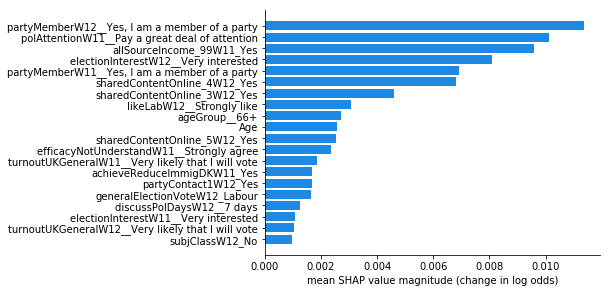

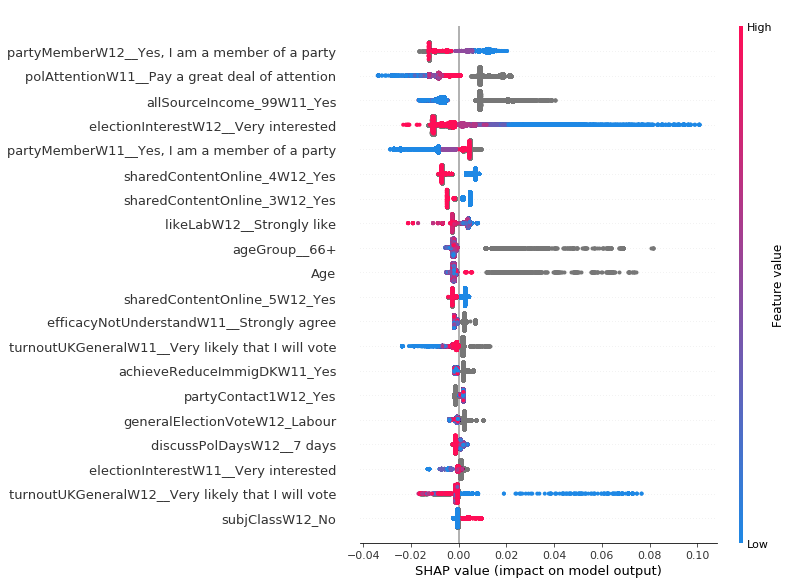

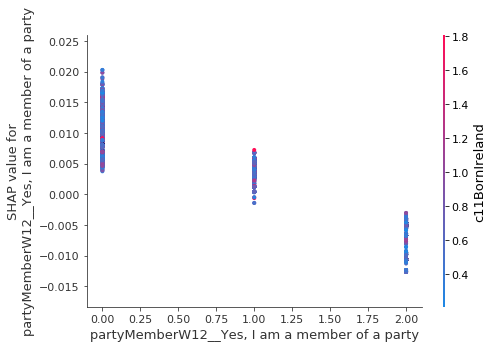

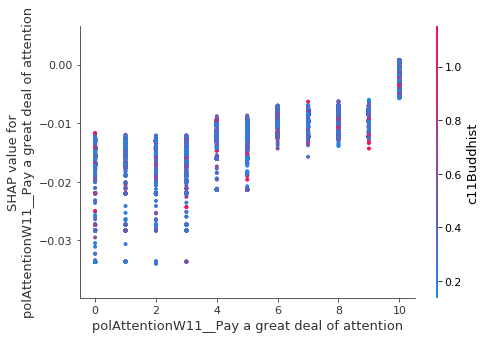

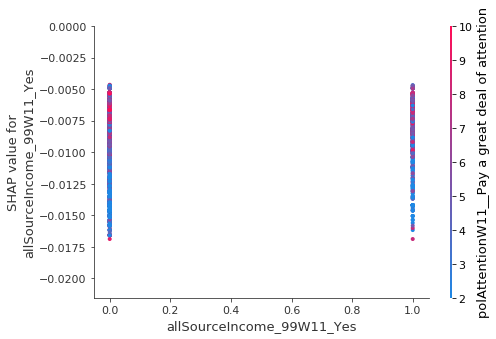

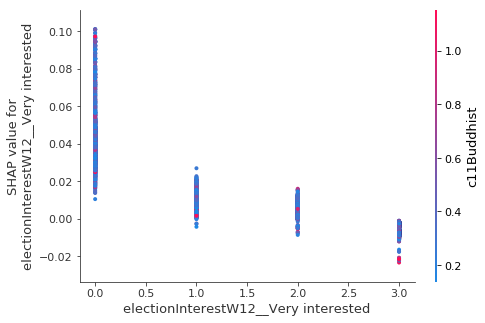

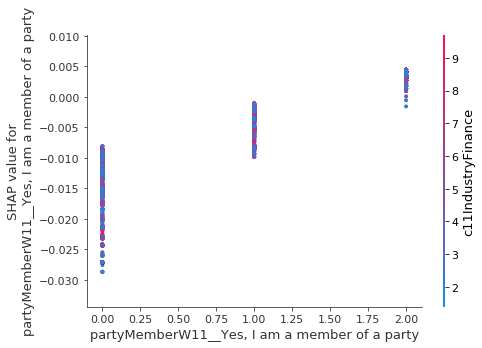

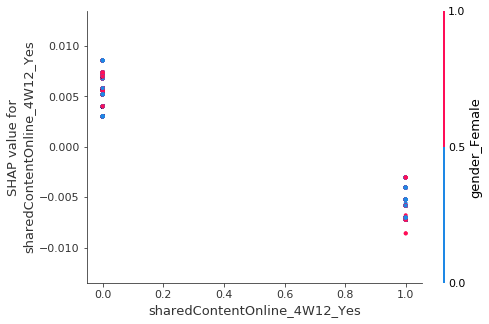

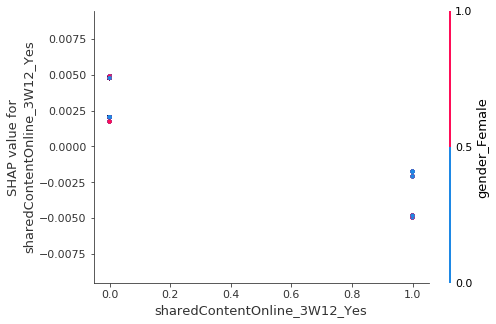

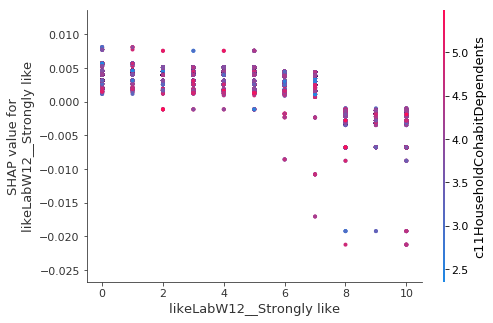

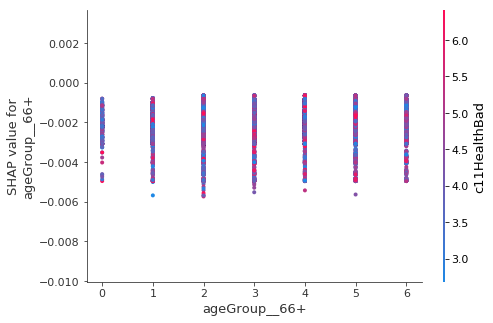

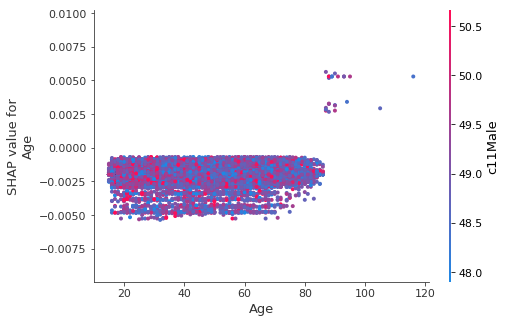

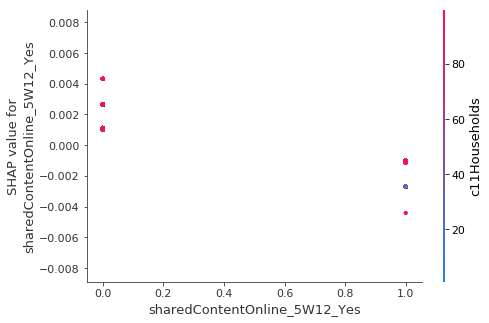

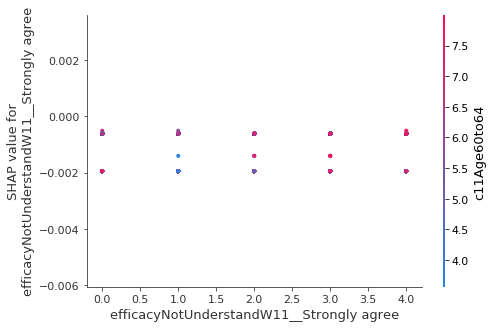

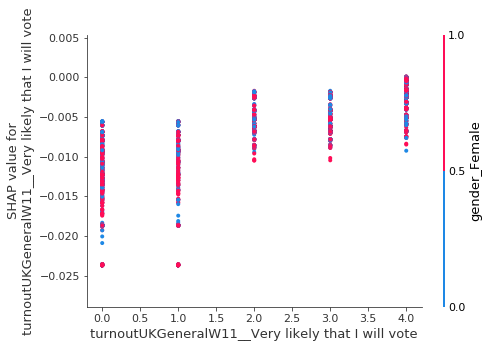

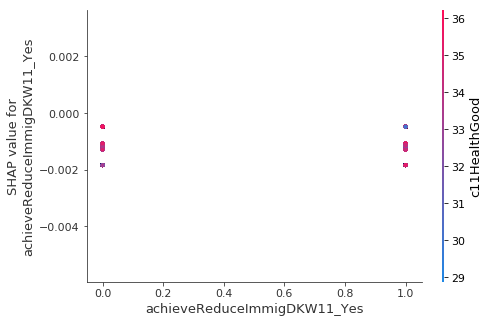

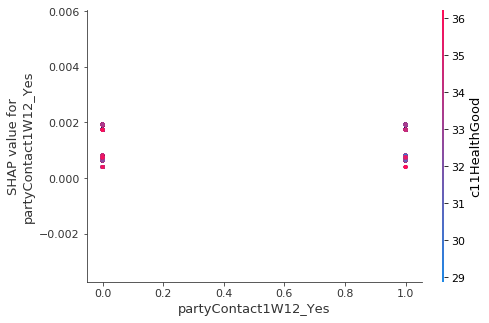

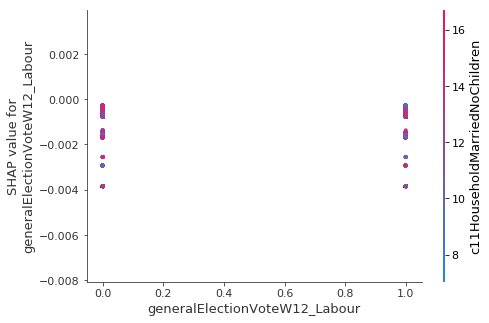

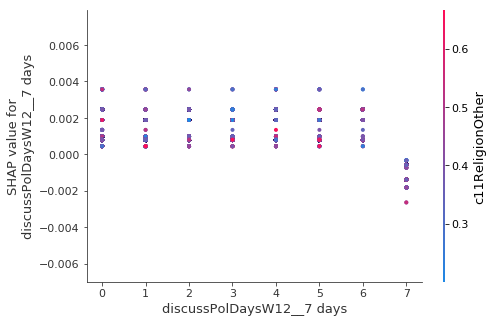

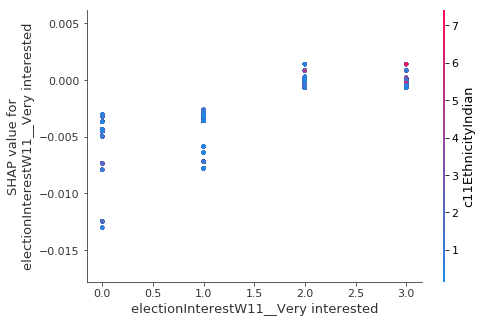

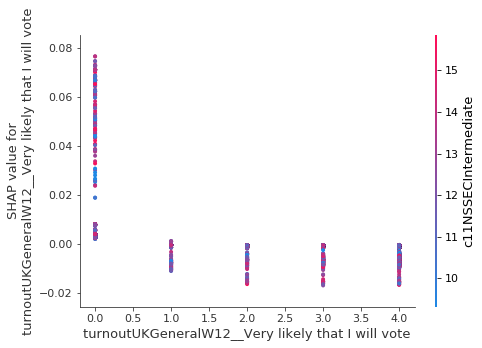

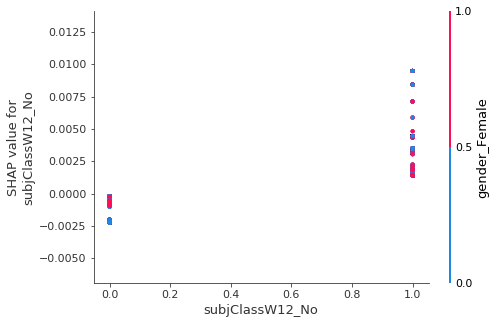

partyIdW13_No - none 13
missing vals in sample weights: 37429
[0]	validation_0-rmse:0.55902
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.541183
[2]	validation_0-rmse:0.524147
[3]	validation_0-rmse:0.508021
[4]	validation_0-rmse:0.492698
[5]	validation_0-rmse:0.478069
[6]	validation_0-rmse:0.46419
[7]	validation_0-rmse:0.451017
[8]	validation_0-rmse:0.438544
[9]	validation_0-rmse:0.426648
[10]	validation_0-rmse:0.415454
[11]	validation_0-rmse:0.404957
[12]	validation_0-rmse:0.395035
[13]	validation_0-rmse:0.385537
[14]	validation_0-rmse:0.376739
[15]	validation_0-rmse:0.368354
[16]	validation_0-rmse:0.360455
[17]	validation_0-rmse:0.352914
[18]	validation_0-rmse:0.346085
[19]	validation_0-rmse:0.339612
MSE: 0.12, MAE: 0.27, EV: 0.10, R2: -0.59


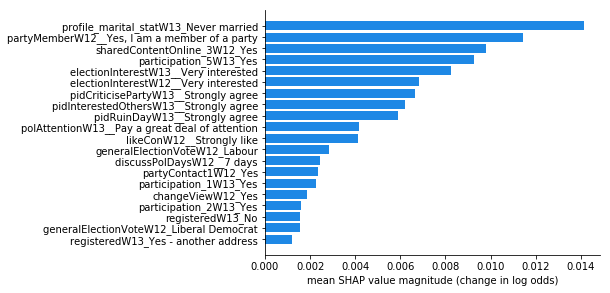

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


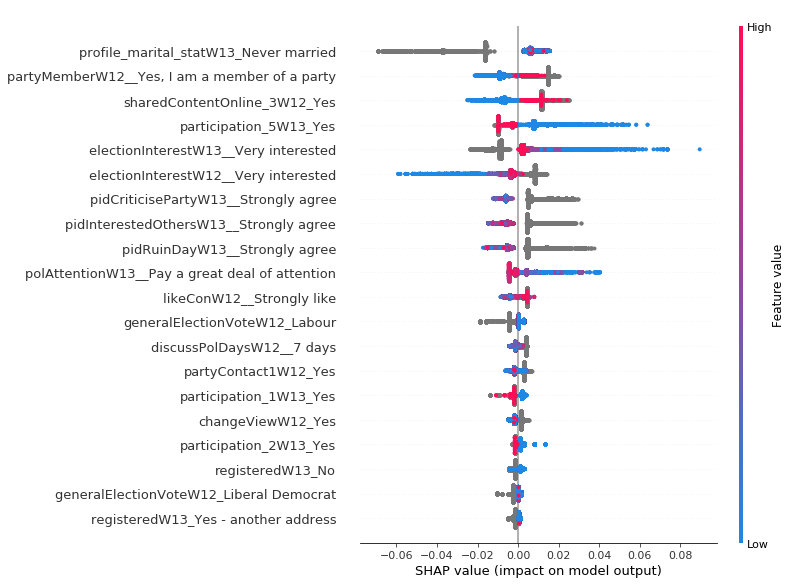

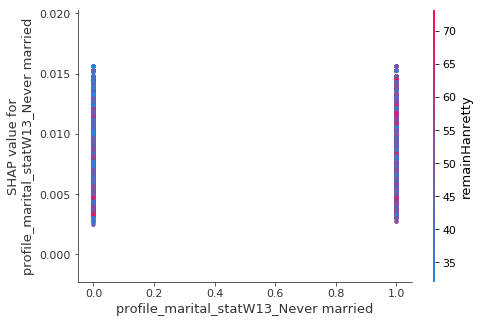

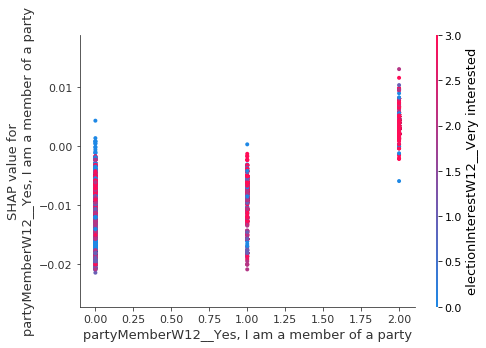

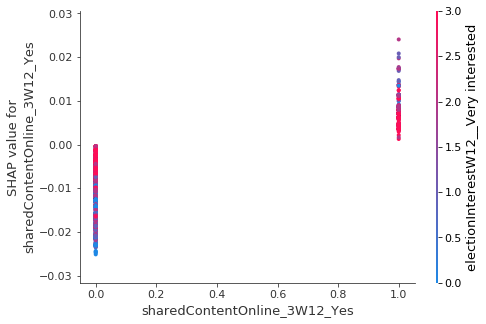

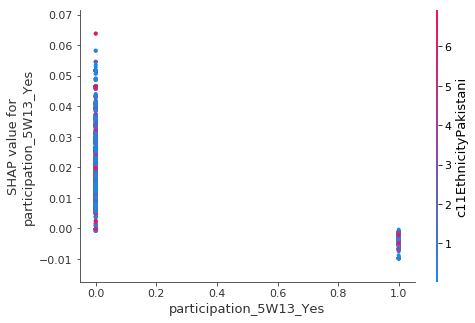

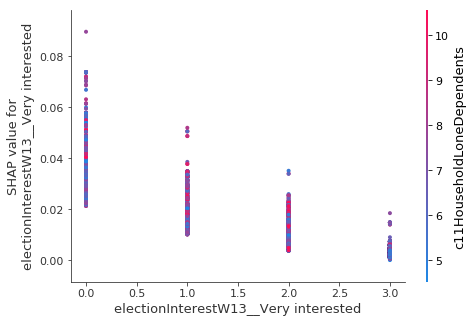

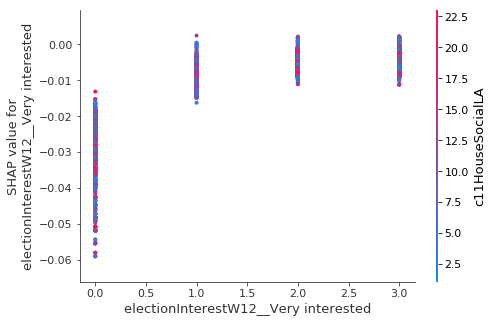

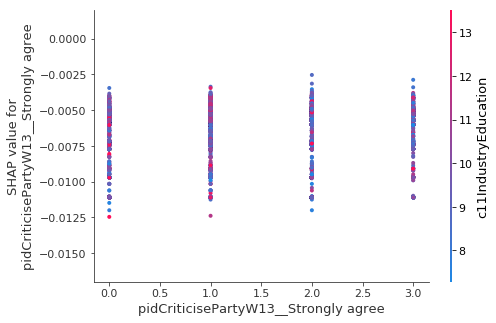

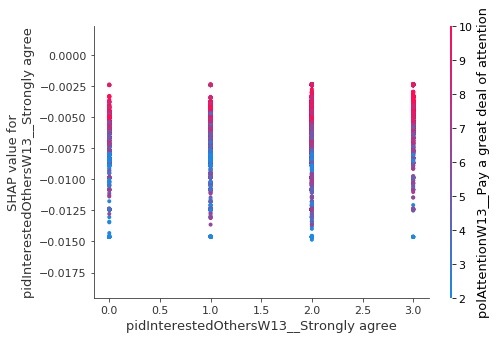

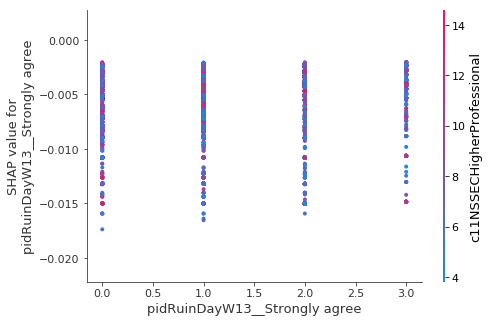

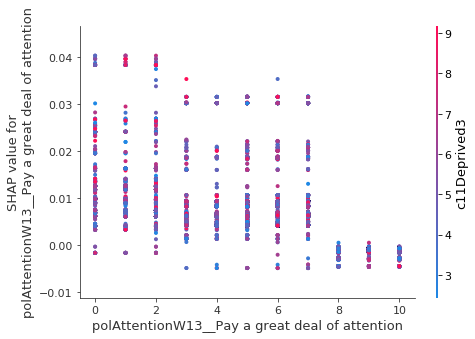

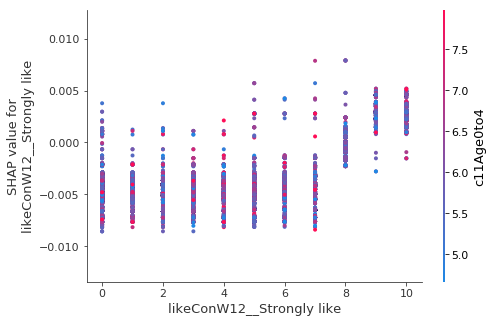

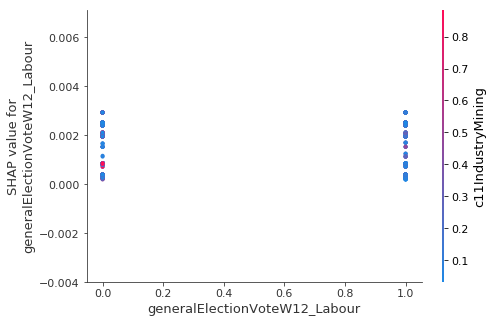

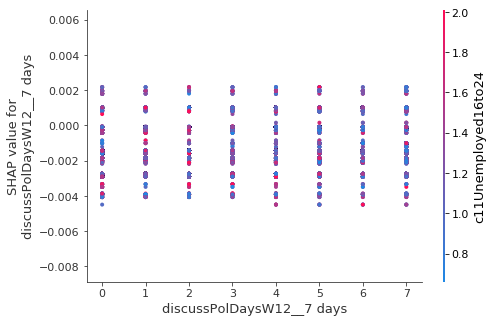

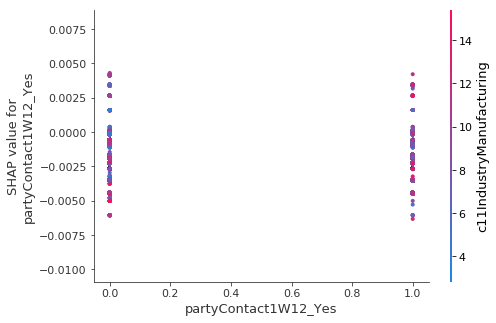

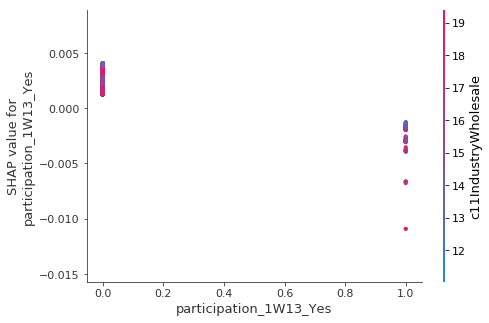

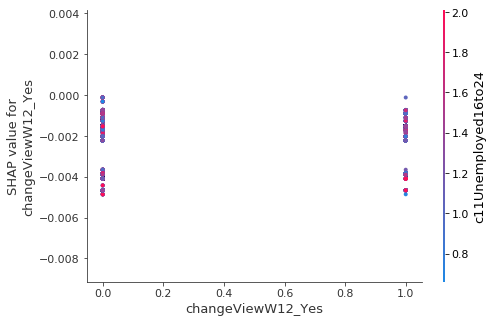

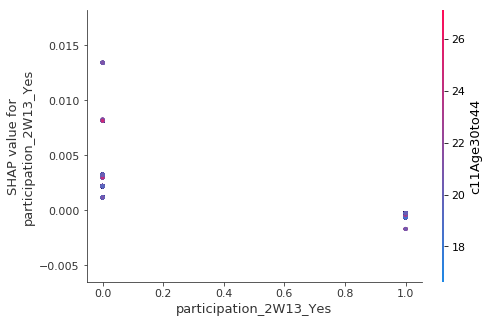

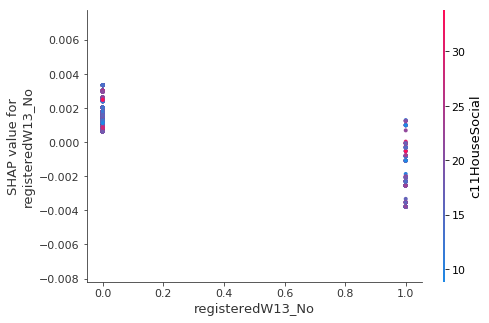

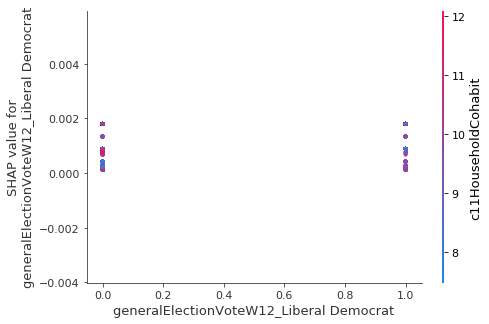

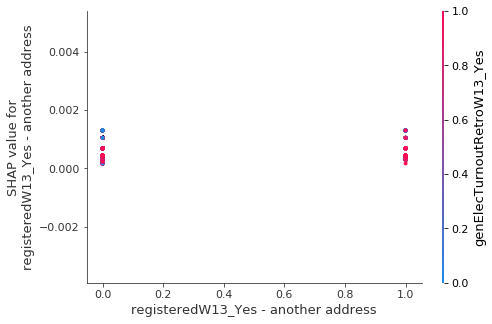

In [63]:
# for target_var,base_var in zip(var_list,base_list):
for target_var in var_list:
    wave_no = int( re.search( 'W(\d+)($|_)', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]    
    print( target_var, wave_no )  
    # mask = BES_reduced_with_na[target_var].notnull()
    mask = party_id_none_delta[target_var].notnull()
    # target = BES_reduced_with_na[target_var][mask]
    target = party_id_none_delta[target_var][mask]
    
    
#     mask = immigDiff[target_var].notnull()
    if sum(mask)<100:
        continue
#     target = immigDiff[target_var][mask]
    
    train  = BES_reduced_with_na[mask]
    
    # drop variables from other waves
#     other_waves = "("+"|".join([num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]) +")" +"([^0-9-]|$)"
#     train = train.drop( [x for x in train.columns if re.search(other_waves,x)] , axis=1 )       
    
    for var_stub in var_stub_list:
        train = train.drop([x for x in train.columns if var_stub in x], axis=1)    
  

    sample_weights = weights[weight_var][mask]
    print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
    sample_weights = sample_weights.fillna(sample_weights.median())

    output_subfolder = BES_output_folder + "xgboost_"+Treatment + os.sep + target_var.replace(">","") + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )


    ############################

    alg = XGBRegressor(
     learning_rate =0.04,
     n_estimators= 20,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.75,
     colsample_bytree=0.9,
     colsample_bylevel=.85,
     objective= 'reg:linear',
     scale_pos_weight=1.0,
     reg_alpha=0,
     reg_lambda=1,
     njobs=3,
     seed=27)

    # split data into train and test sets
    # fit, validate and find overfitting limit
    seed = 7
    test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



    eval_set = [(X_test, y_test)]

    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)

    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

    ####################################
    # fit to full dataset at non-overfitting level
    alg.fit(train, target, verbose=True, sample_weight= sample_weights)




    shap_values = shap.TreeExplainer(alg).shap_values(train);


    #################################
    threshold = .1
    min_features = 20
    global_shap_vals = np.abs(shap_values).mean(0)[:-1]
    n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
    if n_top_features <min_features:
        n_top_features = min_features



    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

    plt.show()

    ####################
    fig = plt.figure()
    shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
    fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')



    ##################
    count = 0
    for name in train.columns[inds[::-1]]:
        fig = plt.figure(figsize = (16,10))    
        shap.dependence_plot(name, shap_values, train)
        fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_")[0:30] + ".png", bbox_inches='tight')
        count = count + 1

In [ ]:
# likeCon, likeLab, pid???, decidedVote, infoSource???, leftRight, ptv???, partyMember, trustMPs, electionInterest
# dutyToVote2

In [37]:
immigDiff.notnull().sum()

Delta_ptvLabW2      6740
Delta_ptvLabW3     11993
Delta_ptvLabW4     11806
Delta_ptvLabW5     14108
Delta_ptvLabW6     14070
Delta_ptvLabW7     10593
Delta_ptvLabW8         4
Delta_ptvLabW9      6543
Delta_ptvLabW10    19380
Delta_ptvLabW11    21990
Delta_ptvLabW12     6320
Delta_ptvLabW13     6589
dtype: int64

In [27]:
del BES_Panel

In [26]:
import gc
gc.collect()

0

'../BES_analysis_output/xgboost_test\\partydiffconlabW5__There is not much difference between them\\'

In [36]:
name.replace("/","_")[0:30]

'conToneW5__5 - Focused mainly '